# 오토인코더 로드

In [ ]:
# 이 셀에서 ae_model.h5라는 오토인코더를 로드
from tensorflow.keras.models import load_model
import tensorflow as tf

ae_model = load_model(
    "ae_model.h5",
    custom_objects={"mse": tf.keras.losses.MeanSquaredError()}
)

In [ ]:
# SVM 로드 -> ocsvm_loaded로 사용
import joblib

loaded = joblib.load("ppg_ocsvm_model_1203.joblib")
ocsvm_loaded = loaded["model"]
scaler_loaded = loaded["scaler"]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.signal as signal
from scipy.interpolate import interp1d
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### 함수 정의 (숨김코드실행)
> prepare_time_axis() ~ waveform 만드는 함수까지



1.   **prepare_time_axis(df)**:

```
입력: df (컬럼에 t_us 포함)
출력: df (초 단위 시간축 time_s 컬럼이 추가된 복사본), fs_est (추정된 샘플링 주파수)
```

2.   **design_bandpass(fs, low, high, order=2)**

```
입력: fs (샘플링 주파수), low (하한 컷오프(Hz)), high (상한 컷오프(Hz)). order (필터 차수)
출력: b, a (bandpass filter 계수)
```

3.  **apply_bandpass(df, b, a, ppg_col="ppg")**
```
입력: df, b, a (필터 계수), ppg_col (필터링 대상 컬럼명)
출력: df_filt (ppg_filt 컬럼이 추가된 DataFrame)
```

4. **detect_systolic_peaks(time_s, ppg, fs, min_hr_bpm=40, max_hr_bpm=180)**

```
입력: time_s (초 단위 시간축 배열), ppg (PPG 신호 배열), fs (샘플링 주파수), min_hr_bpm, max_hr_bpm (심박수 범위)
출력: peaks (peak 인덱스 배열), props (peak 특성(dict))
```

5. **find_local_valley(ppg, center_idx, search_radius_samples)**

```
입력: ppg (신호 배열), center_idx (검색 중심 index), search_radius_samples (탐색 반경)
출력: valley_idx (valley 인덱스)
```

6. **find_foot_points(time_s, ppg, peaks, fs)**

```
입력: time_s (시간축 배열), ppg (신호 배열), peak (peak 인덱스 배열), fs (샘플링 주파수)
출력: start_indices (각 피크의 시작 valley index 리스트), end_indices (각 피크의 끝 valley index 리스트)
```

7.  **compute_pulse_width(time_s, ppg, start_idx, peak_idx, end_idx)**
```
입력: time_s (배열). ppg (배열), start_idx, peak_idx, end_idx
출력: Pw (Pulse Width (float) 또는 None)
```

8.  **compute_ab_ratio(time_s, ppg, start_idx, peak_idx, end_idx)**
```
출력: Ab_over_Aa (float 또는 None)
```

9. **extract_pulse_features(df, fs, ppg_col="ppg_filt", label=None)**
```
입력: df (필터된 데이터프레임), fs (샘플링 주파수), ppg_col (PPG 컬럼명), label (라벨 (옵션))
출력: features_df (각 pulse의 특징이 담긴 DataFrame),
(peaks, start_indices, end_indices) (peak 및 valley 인덱스들)
```

10. **extract_pulse_waveforms(df_signal, features_df, seq_len=150)**
```
입력: df_signal (PPG 신호 df). features_df (pulse 시작/종료 인덱스 포함 DF), seq_len (resample 길이)
출력: pulses ((N, seq_len) shape의 numpy array)
```

# 아래 코드 실행

In [2]:
# @title
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.grid'] = True

def prepare_time_axis(df):
    """pd의 df를 인자로 받아서 copy후 time_s컬럼에 기존 t_us (마이크로초 단위)를 초단위 변환"""
    df = df.copy()

    # t_us: microseconds → seconds
    df["time_s"] = df["t_us"] * 1e-6

    # 샘플링 주파수 추정
    t = df["time_s"].values
    dt = np.diff(t) # np.diff(t)는 연속된 원소의 차이를 구하는 함수
    # df는 연속된 시간 값들의 차이(Δt)만 모아놓은 1차원 배열이 됨

    dt_med = np.median(dt) # 간격들의 중앙값 활용
    fs_est = 1.0 / dt_med # 추정된fs = (1 / 샘플 간격)

    print(f"추정된 샘플링 주파수 ≈ {fs_est:.2f} Hz")

    return df, fs_est

def design_bandpass(fs, low, high, order=2):
    """샘플링 주파수, 상/하한 컷오프 주파수, 필터 차수(기본 2) 입력받아서,
    설계된 대역통과 필터의 계수 반환 -> signal.filtfilt(b, a, x)로 실제 신호에 적용"""
    nyq = 0.5 * fs
    low_n  = low / nyq
    high_n = high / nyq
    b, a = signal.butter(order, [low_n, high_n], btype='band')
    return b, a

def apply_bandpass(df, b, a, ppg_col="ppg"):
    """컬럼명(ppg)을 전달받아서 실제로 대역폭 필터를 적용해서..."""
    # PPG 신호(df[ppg_col])를 numpy 배열로 가져옴
    x = df[ppg_col].values.astype(float)
    x_filt = signal.filtfilt(b, a, x)   # filtfilt(b, a, x)로 필터 적용

    # 새로운 df 생성, 새 컬럼으로 필터링된 신호를 추가
    df_filt = df.copy()
    df_filt[ppg_col + "_filt"] = x_filt
    return df_filt # 새로운 데이터프레임 (ppg_filt 컬럼 추가) 반환

def detect_systolic_peaks(time_s, ppg, fs, min_hr_bpm=40, max_hr_bpm=180):
    """시간 축(초), ppg 신호, 샘플링 주파수, 허용 가능한 최대, 최소 심박수를 입력받고
    """
    # 최대 심박수를 기준으로 peak간의 최소(minimum?) 간격을 설정
    min_distance_sec = 60.0 / max_hr_bpm   # Ex. HR이 180이면 60/180 ≈ 최소 간격 0.33s
    min_distance_samples = int(min_distance_sec * fs) # 신호는 sample 단위 -> 샘플 개수로 바꿔야
    # PPG에서 peak(심박)를 찾을 때, 심박수가 너무 가까이 두 번 찍히는 건 잘못된 peak
    # 위의 예제에서 각 beat 사이 간격 = 1/3초 = "0.33초로 제한"

    # prominence는 대략 signal range의 일부로 설정
    # 잡음 peak를 제외하기 위한 임계치? -> 두드러지는 값 설정?
    prom = 0.1 * (np.max(ppg) - np.min(ppg))

    # signal.find_peaks() 사용하여 봉우리 감지
    peaks, props = signal.find_peaks(
        ppg,
        distance=min_distance_samples,
        prominence=prom
    )

    print(f"Detected {len(peaks)} systolic peaks.")
    return peaks, props

def find_local_valley(ppg, center_idx, search_radius_samples):
    # 신호 범위를 넘기지 않도록 범위 조절
    # [center_idx - r, center_idx + r] 구간만 살펴봄
    start = max(center_idx - search_radius_samples, 0)
    end = min(center_idx + search_radius_samples, len(ppg)-1)
    local_segment = ppg[start:end+1]

    # 구간에서 최소값 위치 찾기
    local_min_idx = np.argmin(local_segment)

    # 전체 ppg 기준의 인덱스로 변환
    valley_idx = start + local_min_idx
    return valley_idx # valley 인덱스 반환

def find_foot_points(time_s, ppg, peaks, fs):
    """peak 이전 구간에서 valley, peak 이후 구간에서 valley 찾기
    심박 1주기를 정의할 수 있도록 도와주는 함수
    [start valley] → systolic peak → [end valley]"""
    Ts_min, Ts_max = 0.15, 0.26  # 일반적인 PPG에서는 peak 기준 0.15~0.26초 전 구간에 start valley 존재
    Te_min, Te_max = 0.44, 0.74  # 이것도 일반적인 구간

    start_indices = []
    end_indices = []

    for i, pk in enumerate(peaks):
        t_peak = time_s[pk]

        # search range in samples
        Ts_min_samp = int(Ts_min * fs)
        Ts_max_samp = int(Ts_max * fs)
        Te_min_samp = int(Te_min * fs)
        Te_max_samp = int(Te_max * fs)

        # ---- find start valley (before peak) ----
        start_min = max(pk - Ts_max_samp, 0)
        start_max = max(pk - Ts_min_samp, 0)
        if start_max <= start_min:
            start_indices.append(None)
        else:
            local_seg = ppg[start_min:start_max+1]
            local_min_idx = np.argmin(local_seg)
            start_idx = start_min + local_min_idx
            start_indices.append(start_idx)

        # ---- find end valley (after peak) ----
        end_min = min(pk + Te_min_samp, len(ppg)-1)
        end_max = min(pk + Te_max_samp, len(ppg)-1)
        if end_max <= end_min:
            end_indices.append(None)
        else:
            local_seg = ppg[end_min:end_max+1]
            local_min_idx = np.argmin(local_seg)
            end_idx = end_min + local_min_idx
            end_indices.append(end_idx)

    return start_indices, end_indices

def compute_pulse_width(time_s, ppg, start_idx, peak_idx, end_idx):
    """PPG 한 주기에서 Pulse Width(PW) 계산
    초단위 시간축 배열, ppg 신호, 주기 시작/끝/수축기 피크 인덱스를 받아서 계산"""
    if start_idx is None or end_idx is None:
        return None

    v_start = ppg[start_idx]
    v_peak  = ppg[peak_idx]
    As = v_peak - v_start
    if As <= 0: # Peak가 valley보다 낮으면 → 비정상 → None 반환
        return None

    # valley와 peak 절반 높이 정의
    half_level = v_start + As * 0.5

    # start_idx → peak_idx 구간 잘라서 seg1으로 정의
    seg1 = ppg[start_idx:peak_idx+1]
    t1 = time_s[start_idx:peak_idx+1]

    # find index where seg1 crosses half_level
    try:
        # 절반 높이보다 커지는 시점?
        idx_before = np.where(seg1 < half_level)[0]
        idx_after = np.where(seg1 >= half_level)[0]
        # simple approach: first index above half_level
        if len(idx_before) > 0 and len(idx_after) > 0:
            i1 = idx_after[0] # 딱 절반 높이(half_level까지 올라왔을 때)
        else:
            i1 = None
    except:
        i1 = None

    # Half-level 하강 시점 찾기
    seg2 = ppg[peak_idx:end_idx+1]
    t2 = time_s[peak_idx:end_idx+1]

    try:
        idx_after2 = np.where(seg2 < half_level)[0]
        if len(idx_after2) > 0:
            i2 = idx_after2[0]
        else:
            i2 = None
    except:
        i2 = None

    if (i1 is None) or (i2 is None):
        return None

    # i1, i2가 전부 탐지 되었을 때 list에 저장
    t_half1 = t1[i1]
    t_half2 = t2[i2]
    Pw = t_half2 - t_half1
    if Pw <= 0:
        return None
    return Pw

def compute_ab_ratio(time_s, ppg, start_idx, peak_idx, end_idx):
    if start_idx is None or end_idx is None:
        return None

    seg = ppg[start_idx:end_idx+1]
    t_seg = time_s[start_idx:end_idx+1]

    # second derivative
    d1 = np.gradient(seg, np.mean(np.diff(t_seg)))
    d2 = np.gradient(d1, np.mean(np.diff(t_seg)))

    # we expect 'a' near systolic upstroke, 'b' early diastole
    # split segment into two halves as rough approximation
    mid_idx = len(seg) // 2

    # find max in first half (a-wave)
    a_region = d2[:mid_idx]
    if len(a_region) == 0:
        return None
    a_idx_local = np.argmax(a_region)
    Aa = a_region[a_idx_local]

    # find max in second half (b-wave) - could be smaller
    b_region = d2[mid_idx:]
    if len(b_region) == 0:
        return None
    b_idx_local = np.argmax(b_region)
    Ab = b_region[b_idx_local]

    if Aa == 0:
        return None

    return Ab / Aa

def extract_pulse_features(df, fs, ppg_col="ppg_filt", label=None):
    """
    위에서 정의한 5개 특징점들을 모두 뽑아내는 함수
    """
    time_s = df["time_s"].values # df.values는 DataFrame 전체를 넘파이 2차원 배열로 바꾼 값 반환
    ppg = df[ppg_col].values.astype(float)

    # 1) detect systolic peaks
    peaks, _ = detect_systolic_peaks(time_s, ppg, fs) # peak 인덱스 배열 반환, props (peak 특성(dict))는 익명으로 받음(_)
    # 2) find foot points (start/end valleys) for each peak
    start_indices, end_indices = find_foot_points(time_s, ppg, peaks, fs)

    # 3) features per pulse 리스트 준비
    feature_rows = []

    dropped = 0 # ← 걸러진(continue된) 심주기 개수 기록

    for i, pk in enumerate(peaks): #
        s_idx = start_indices[i] # (peaks 기준) 심주기 시작으로 판단된 부분
        e_idx = end_indices[i] # 심주기 끝으로 판단된 부분

        # -------- 걸러지는 조건들 --------
        if (s_idx is None) or (e_idx is None):
            dropped += 1
            continue
        if s_idx >= pk or pk >= e_idx: # valley-peak-valley 순서가 아닌 이상한 구조
            dropped += 1
            continue

        # 초 단위 심주기 시작-피크-끝
        t_start = time_s[s_idx]
        t_peak  = time_s[pk]
        t_end   = time_s[e_idx]

        # 진폯 (피크에서의 ppg 신호 크기 - 시작점 크기)
        As = ppg[pk] - ppg[s_idx]
        if As <= 0: # 음수가 나오면 이상한 값
            dropped += 1

            continue

        # Crest time Tc 조건 추가 -> 변동 X
        Tc = t_peak - t_start
        if Tc < 0.1 or Tc > 0.5:
            dropped += 1
            continue
        # --------------------------------

        # Pulse width Pw
        Pw = compute_pulse_width(time_s, ppg, s_idx, pk, e_idx)

        # 현재 피크와 다음 피크 사이의 시간 간격 계산, Pi/As 계산
        # 피크 검출 자체에서 오류가 발생하면 이 부분에서도 잘못된 값이 계산됨

        # Pulse interval Pi 계산, 다음 피크가 존재하면 다음 피크까지의 시간 계산
        if i < len(peaks) - 1:
            Pi = time_s[peaks[i+1]] - t_peak
        else:
            Pi = None

        # 피크 존재하고 As가(진폭) 정상값(양수)라면 Pi/As 계산
        if (Pi is not None) and (As > 0):
            Pi_over_As = Pi / As
        else:
            Pi_over_As = None

        # Ab_w / Aa_w from second derivative
        Ab_over_Aa = compute_ab_ratio(time_s, ppg, s_idx, pk, e_idx)
        if Ab_over_Aa is not None and Ab_over_Aa > 3.0: # 조건 추가 -> 변동 X
            dropped += 1
            continue

        # 한 심주기에서 나온 것들을 딕셔너리로 저장
        feature_rows.append({
            "t_peak": t_peak,
            "As": As,
            "Pw": Pw,
            "Pi_over_As": Pi_over_As,
            "Tc": Tc,
            "Ab_over_Aa": Ab_over_Aa,
            "start_idx": s_idx,
            "peak_idx": pk,
            "end_idx": e_idx,
            "label": label
        })
    # 여기도 함수 내부 (for 반복문 바깥)
    features_df = pd.DataFrame(feature_rows)
    print(f"{dropped}개의 심주기 오류 발생으로 Drop")
    print(f"Extracted {len(features_df)} pulses with features.")
    return features_df, (peaks, start_indices, end_indices)

def extract_pulse_waveforms(df_signal, features_df, seq_len=150):
    """
    Extract pulse waveforms using start_idx and end_idx from features_df.
    Resample each pulse to fixed length seq_len.
    """
    pulses = []
    for _, row in features_df.iterrows():
        start_time = int(row["start_idx"])
        end_time = int(row["end_idx"])

        x = df_signal["ppg_filt"].values[start_time:end_time+1] # if "ppg_filt" in df_signal.columns else df_signal["ppg_filt_smaf"].values[start_time:end_time+1]

        # Resample to seq_len
        old_indices = np.linspace(0, 1, len(x))
        new_indices = np.linspace(0, 1, seq_len)
        x_resampled = np.interp(new_indices, old_indices, x)
        pulses.append(x_resampled)

    print(f"Extracted {len(pulses)} pulses.")
    return np.array(pulses)  # shape: (N, seq_len)

### 여러 csv 파일 입력받아 전처리 후 합치는 코드 (숨김 처리)

In [ ]:
# @title
# # 경로 설정 후 전처리 파이프라인
# import os
# import glob
# import pandas as pd
# import numpy as np
# from scipy import signal

# low_cut  = 0.5   # Hz
# high_cut = 6.0   # Hz
# order = 2        # 예시값
# seq_len = 150

# file_list = sorted(glob.glob("esther_static_*.csv"))
# print(file_list)

# def concate_csv(file_list, filename):
#   if len(file_list) == 0:
#     print("file_list에 파일이 없습니다.")
#     return 0

#   low_cut  = 0.5   # Hz
#   high_cut = 6.0   # Hz
#   order = 2        # 예시값
#   seq_len = 150

#   # -------------------------------
#   # 결과 저장용 리스트
#   # -------------------------------
#   all_pulses = []        # 모든 pulse waveform 저장
#   all_labels = []        # pulse에 대한 label (선택사항)
#   for path in file_list:
#       print(f"\nfile: {path}")

#       # 1) CSV 로드
#       df = pd.read_csv(path)
#       # 2) 시간축 구성
#       df, fs = prepare_time_axis(df)
#       # 3) Bandpass 필터 설계 및 적용
#       b, a = design_bandpass(fs, low_cut, high_cut, order)
#       df_filt = apply_bandpass(df, b, a)
#       # 4) Feature 추출 (peaks, segment 정보 포함)
#       features, (peaks, starts, ends) = extract_pulse_features(
#           df_filt,
#           fs,
#           ppg_col="ppg_filt",
#           label=os.path.basename(path).replace(".csv", "")
#       )
#       # 5) Pulse waveform 추출 (모든 pulse를 150길이로 정규화)
#       pulses = extract_pulse_waveforms(
#           df_filt,
#           features,
#           seq_len=seq_len
#       )
#       # 넘파이 -> 데이터프레임 변환
#       pulses_df = pd.DataFrame(pulses)

#       # 6) 결과 리스트에 누적
#       all_pulses.append(pulses_df)
#       all_labels.extend([os.path.basename(path)] * len(pulses))

#   # -------------------------------
#   # 전체 pulse 데이터를 하나로 합치기
#   # -------------------------------
#   merged_pulses = pd.concat(all_pulses, ignore_index=True)

#   # label 컬럼 추가 (선택 사항)
#   merged_pulses['label'] = all_labels

#   # -------------------------------
#   # 최종 CSV 저장
#   # -------------------------------
#   merged_pulses.to_csv(f"{filename}.csv", index=False)
#   print(f"{filename}.csv 생성 완료")

# concate_csv(file_list, "esther_static_3m")

Imports completed.
file1: /content/esther_static_2_1127_norm.csv
file2: /content/p4_static_norm.csv
Static shape: (5958, 6)
Far-wrist shape: (5967, 6)

Static head:


,t_us,dt_us,ax,ay,az,ppg
0,19608582,10017,-0.324585,-0.722290,0.628784,536
1,19618590,10008,-0.324219,-0.722900,0.627930,541
2,19628587,9997,-0.323120,-0.722168,0.627319,544
3,19638589,10002,-0.323486,-0.720947,0.627075,544
4,19648588,9999,-0.322876,-0.720093,0.626587,548



Far-wrist head:


,t_us,dt_us,ax,ay,az,ppg
0,143485380,10020,0.132080,0.625854,0.724243,524
1,143495385,10005,0.131592,0.625854,0.725952,516
2,143505379,9994,0.130737,0.625488,0.724976,520
3,143515360,9981,0.132202,0.627930,0.724243,516
4,143525367,10007,0.131958,0.626953,0.724121,511


추정된 샘플링 주파수 ≈ 100.00 Hz
추정된 샘플링 주파수 ≈ 100.00 Hz

Plotting: Static PPG (first 8 seconds)
Using samples = 801 (approx 8 seconds)


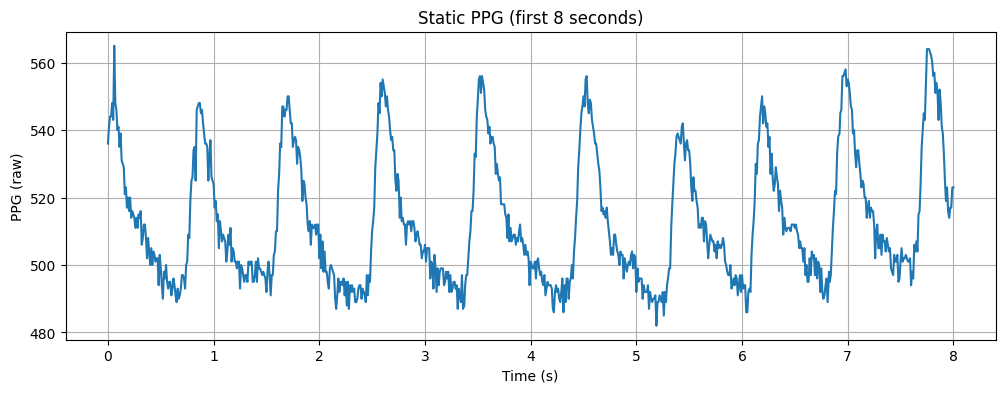


Plotting: Far-wrist PPG (first 8 seconds)
Using samples = 800 (approx 8 seconds)


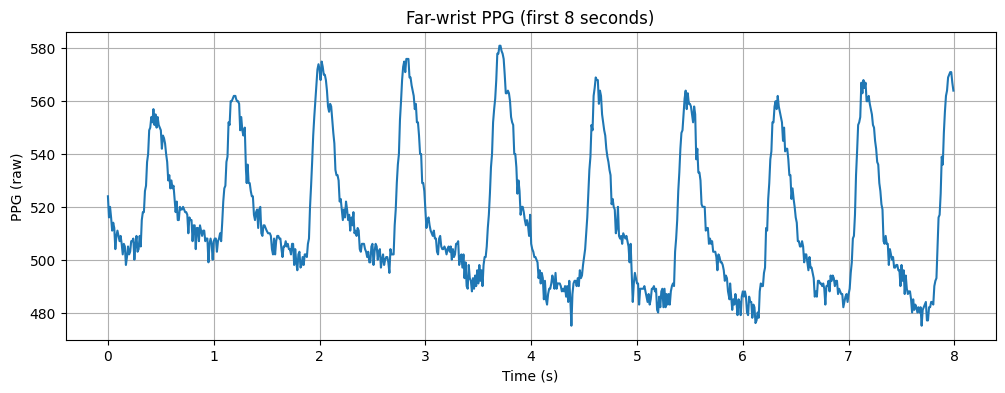

In [124]:
# =============================
# 0. Mount Google Drive
# =============================
# from google.colab import drive
# drive.mount('/content/drive')

# =============================
# 1. Imports
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.grid'] = True

print("Imports completed.")

# =============================
# 2. File paths (EDIT THESE)
# =============================

static_path = "/content/esther_static_2_1127_norm.csv"
farwrist_path = "/content/p4_static_norm.csv"

print("file1:", static_path)
print("file2:", farwrist_path)

# =============================
# 3. Load CSV
# =============================
# pd 데이터프레임화
df_static = pd.read_csv(static_path)
df_farwrist = pd.read_csv(farwrist_path)

print("Static shape:", df_static.shape)
print("Far-wrist shape:", df_farwrist.shape)

print("\nStatic head:")
display(df_static.head())

print("\nFar-wrist head:")
display(df_farwrist.head())

# =============================
# 4. Convert time axis (t_us → seconds) + estimate fs
# =============================
# 시간 축 정리 및 샘플링 주파수 추정
def prepare_time_axis(df):
    """pd의 df를 인자로 받아서 copy후 time_s컬럼에 기존 t_us (마이크로초 단위)를 초단위 변환"""
    df = df.copy()

    # t_us: microseconds → seconds
    df["time_s"] = df["t_us"] * 1e-6

    # 샘플링 주파수 추정
    t = df["time_s"].values
    dt = np.diff(t) # np.diff(t)는 연속된 원소의 차이를 구하는 함수
    # df는 연속된 시간 값들의 차이(Δt)만 모아놓은 1차원 배열이 됨

    dt_med = np.median(dt) # 간격들의 중앙값 활용
    fs_est = 1.0 / dt_med # 추정된fs = (1 / 샘플 간격)

    print(f"추정된 샘플링 주파수 ≈ {fs_est:.2f} Hz")

    return df, fs_est

# df_static은 time_s 컬럼이 추가된 새 df
df_static, fs_static = prepare_time_axis(df_static) # df_static_sec으로 변수명 변경 필요
df_farwrist, fs_farwrist = prepare_time_axis(df_farwrist)

# =============================
# 5. Plot segment (first N seconds)
# =============================
def plot_ppg(df, fs, title, duration_sec=8):
    """df, 샘플링 주파수(추정값), 제목, 구간 길이를 인자로 받아서 ppg 그래프 출력"""
    # .values를 활용해 각 컬럼 값들을 numpy 배열로 가져옴
    t = df["time_s"].values # 가로축은 시간축
    x = df["ppg"].values # 세로축은 ppg 시그널로 plot 생성

    t0 = t[0]
    # duration_sec을 기준으로 필요한 범위만 선택
    mask = (t - t0) <= duration_sec

    print(f"\nPlotting: {title}")
    # 샘플 개수가 duration_sec × fs 근접해야 정상
    print(f"Using samples = {mask.sum()} (approx {duration_sec} seconds)")

    plt.figure()
    plt.plot(t[mask] - t0, x[mask])
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("PPG (raw)")
    plt.show()

plot_ppg(df_static, fs_static, "Static PPG (first 8 seconds)")
plot_ppg(df_farwrist, fs_farwrist, "Far-wrist PPG (first 8 seconds)")

### 숨김코드: `design_bandpass(fs, low, high, order=2)`
> return b, a

In [ ]:
# @title
# # ---- 2-1. Design Butterworth band-pass filter (0.5–6 Hz, order=2) ----
# low_cut  = 0.5   # Hz
# high_cut = 6.0   # Hz
# order    = 2

# def design_bandpass(fs, low, high, order=2):
#     """샘플링 주파수, 상/하한 컷오프 주파수, 필터 차수(기본 2) 입력받아서,
#     설계된 대역통과 필터의 계수 반환 -> signal.filtfilt(b, a, x)로 실제 신호에 적용"""
#     nyq = 0.5 * fs
#     low_n  = low / nyq
#     high_n = high / nyq
#     b, a = signal.butter(order, [low_n, high_n], btype='band')
#     return b, a

In [125]:
import scipy.signal as signal

low_cut  = 0.5   # Hz
high_cut = 6.0   # Hz
order    = 2

print("Using fs_static =", fs_static, "Hz")
print("Using fs_farwrist =", fs_farwrist, "Hz")

b_static, a_static = design_bandpass(fs_static,   low_cut, high_cut, order)
b_farwrist, a_farwrist = design_bandpass(fs_farwrist, low_cut, high_cut, order)

print("Filter designed.")

Using fs_static = 100.0000000000199 Hz
Using fs_farwrist = 100.00000000009095 Hz
Filter designed.


### 필터 계수 (b, a)?
PPG 신호를 필터에 넣으면,
* 특정 주파수(예: 0.5~5Hz)만 통과시키고
* 나머지(잡음)는 약하게 만들어 제거하는데,

> 어떻게 약하게 만들고 제거할지를 수학적으로 정한 것이 b, a 계수

> y[n] = b0*x[n] + b1*x[n-1] + b2*x[n-2] ...  -  a1*y[n-1] - a2*y[n-2] ... 처럼 생김

/tmp/ipython-input-1097783574.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freqs, 20 * np.log10(np.abs(h)))


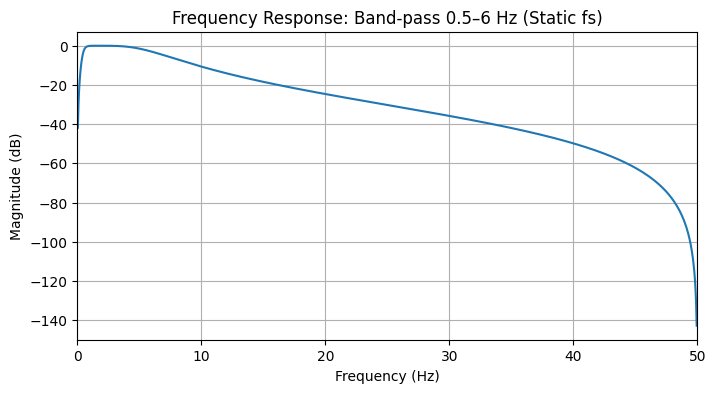

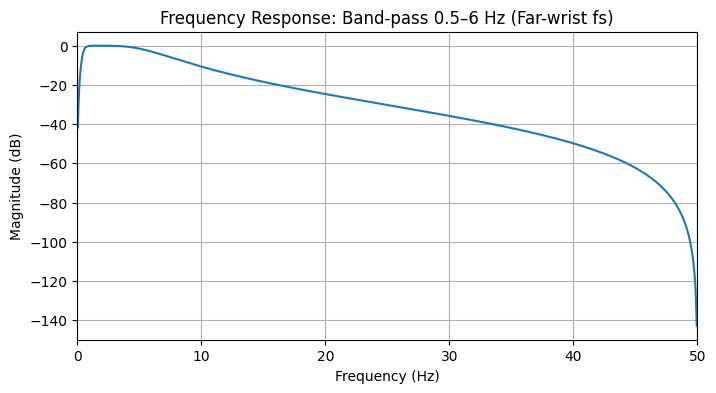

In [126]:
def plot_filter_response(b, a, fs, title):
    """구해진 필터 계수 b, a와 샘플링 주파수, 제목을 전달받아서
    필터가 어떤 주파수를 통과시키고, 어떤 주파수를 억제하는지 그래프 출력"""
    w, h = signal.freqz(b, a, worN=1024)
    freqs = w * fs / (2 * np.pi)

    plt.figure(figsize=(8,4))
    plt.plot(freqs, 20 * np.log10(np.abs(h)))
    plt.title(f"Frequency Response: {title}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True)
    plt.xlim(0, fs/2)
    plt.show()

plot_filter_response(b_static, a_static, fs_static,   "Band-pass 0.5–6 Hz (Static fs)")
plot_filter_response(b_farwrist, a_farwrist, fs_farwrist, "Band-pass 0.5–6 Hz (Far-wrist fs)")

* X축: 주파수(Hz)
* Y축: 크기 응답(dB)
* 어느 구간이 pass-band(통과)이고
* 어느 구간이 stop-band(차단)인지 시각적으로 확인 가능

> 0 dB에 가까우면 → 거의 그대로 통과(= 원본 유지),

> –20 dB, –40 dB… 더 음수일수록 강하게 억제

### 숨김 코드: 대역폭 필터링 함수 `apply_bandpass(df, b, a, ppg_col="ppg")`
> return df_filt # 새로운 데이터프레임 (ppg_filt 컬럼 추가) 반환

In [ ]:
# @title
# def apply_bandpass(df, b, a, ppg_col="ppg"):
#     """컬럼명(ppg)을 전달받아서 실제로 대역폭 필터를 적용해서 """
#     # PPG 신호(df[ppg_col])를 numpy 배열로 가져옴
#     x = df[ppg_col].values.astype(float)
#     x_filt = signal.filtfilt(b, a, x)   # filtfilt(b, a, x)로 필터 적용

#     # 새로운 df 생성, 새 컬럼으로 필터링된 신호를 추가
#     df_filt = df.copy()
#     df_filt[ppg_col + "_filt"] = x_filt
#     return df_filt # 새로운 데이터프레임 (ppg_filt 컬럼 추가) 반환

In [127]:
df_static_filt   = apply_bandpass(df_static, b_static, a_static)
df_farwrist_filt = apply_bandpass(df_farwrist, b_farwrist, a_farwrist)

print("Filtering finished.")
print("Columns in df1:", df_static_filt.columns.tolist())
print("Columns in df2:", df_farwrist_filt.columns.tolist())

Filtering finished.
Columns in df1: ['t_us', 'dt_us', 'ax', 'ay', 'az', 'ppg', 'time_s', 'ppg_filt']
Columns in df2: ['t_us', 'dt_us', 'ax', 'ay', 'az', 'ppg', 'time_s', 'ppg_filt']


### mask = (t - t0) <= duration_sec
* PPG의 전체 시간값 배열 t
* t0 = t[0]: 첫 번째 시간값(시작시간, 어떤 장비는 시작시간이 100초일 수도 있어서)
* (t - t0): 각 시간에서 시작 시간(t0)을 빼서 전체 시간을 0초를 기준으로 맞춤
* 예를 들어 duration_sec = 8이면 해당 행(row)의 시간 (0초 기준 정렬)을 보고
* (0.01 <= 8) → True 로 필터링


Plotting before/after for: 1번째 PPG 시각화
Samples used: 501


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


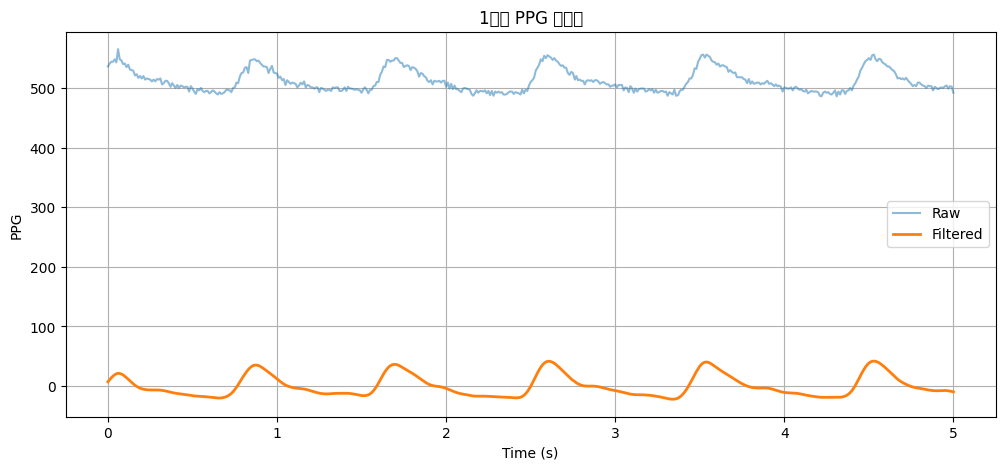


Plotting before/after for: 2번째 PPG 시각화
Samples used: 500


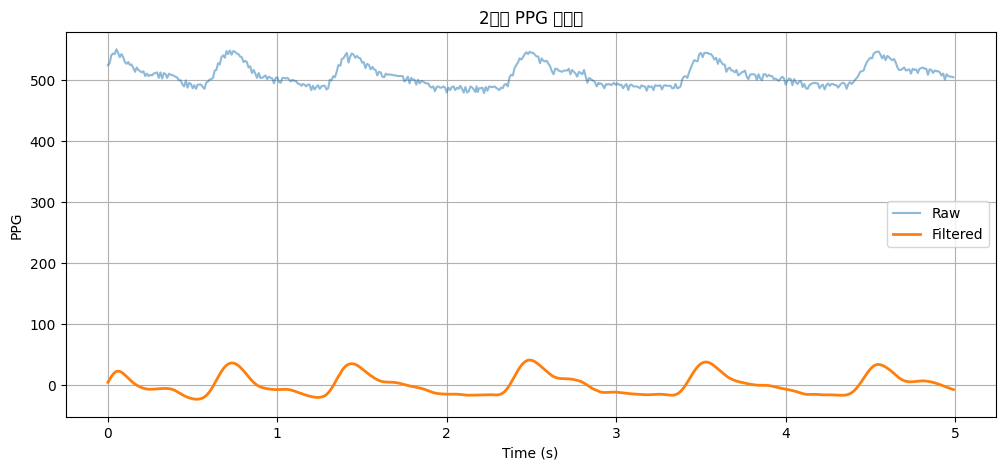

In [7]:
def plot_before_after(df, col_raw, col_filt, title, duration_sec=8):
    """df, 원본 신호와 필터 통과 신호, 제목, 구간 길이 입력받아서 시각화"""
    t = df["time_s"].values # 시간 컬럼
    x_raw  = df[col_raw].values
    x_filt = df[col_filt].values

    # 시간 배열을 생성하고 시작부터 duration_sec만큼 데이터 선택(mask)
    t0 = t[0]
    mask = (t - t0) <= duration_sec

    print(f"\nPlotting before/after for: {title}")
    print(f"Samples used: {mask.sum()}")

    # 같은 구간에서 원본 신호와 필터 신호를 하나의 그래프에 출력
    plt.figure(figsize=(12,5))
    plt.plot(t[mask] - t0, x_raw[mask],  label="Raw",  alpha=0.5)
    plt.plot(t[mask] - t0, x_filt[mask], label="Filtered", linewidth=2)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("PPG")
    plt.legend()
    plt.show()

# 시각화1
plot_before_after(
    df_static_filt,
    col_raw="ppg",
    col_filt="ppg_filt",
    title="1번째 PPG 시각화",
    duration_sec=5
)

# 시각화2
plot_before_after(
    df_farwrist_filt,
    col_raw="ppg",
    col_filt="ppg_filt",
    title="2번째 PPG 시각화",
    duration_sec=5
)

### 원본 PPG = DC 성분(큰 기본값) + AC 성분(심박 파형)

> DC 성분 → 평균 밝기, 손가락 압력, 주변 빛 등 → 값이 300~700 같은 큰 범위

### 대역통과 필터(Band-pass)는 DC를 제거함
> low_cut = 0.5 Hz, high_cut = 6 Hz로 설정 → DC(0 Hz)는 필터 통과대역에 포함되지 않음 (중심값 500(DC 성분)은 모두 제거하고 심박 신호(AC 성분)만 남음)

> 이 AC 신호의 크기는 원래 5~20 정도

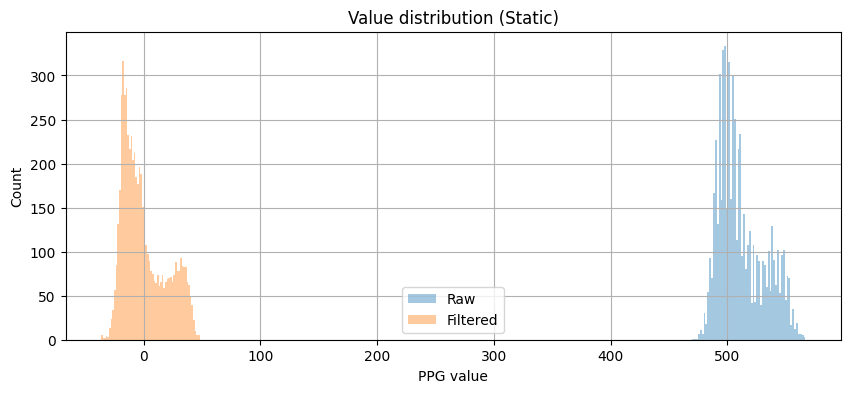

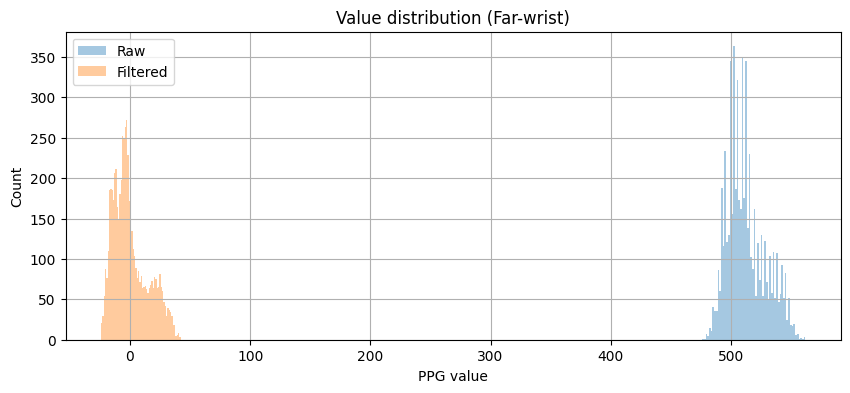

In [8]:
def compare_hist(df, col_raw, col_filt, title):
    plt.figure(figsize=(10,4))
    plt.hist(df[col_raw].values,  bins=60, alpha=0.4, label="Raw")
    plt.hist(df[col_filt].values, bins=60, alpha=0.4, label="Filtered")
    plt.title(title)
    plt.xlabel("PPG value")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

compare_hist(df_static_filt,   "ppg", "ppg_filt",   "Value distribution (Static)")
compare_hist(df_farwrist_filt, "ppg", "ppg_filt", "Value distribution (Far-wrist)")

# 5 개 특징점으로 SVM 학습 (12.03)

In [128]:
# 김에스더 5개 특징 준비
esther_features, (esther_peaks, esther_s_idx, esther_e_edx) = extract_pulse_features(
    df_static_filt,
    fs_static,
    ppg_col="ppg_filt",
    label="esther")

p4_features, (p4_peaks, p4_s_idx, p4_e_edx) = extract_pulse_features(
    df_farwrist_filt,
    fs_farwrist,
    ppg_col="ppg_filt",
    label="p1")

Detected 74 systolic peaks.
2개의 심주기 오류 발생으로 Drop
Extracted 72 pulses with features.
Detected 85 systolic peaks.
0개의 심주기 오류 발생으로 Drop
Extracted 85 pulses with features.


In [129]:
# features df -> csv로 저장
# esther_features.to_csv("esther_features.csv", index=True)
p4_features.to_csv("p4_features.csv", index=True)

In [ ]:
def plot_feature_hist(features_df, col, title):
    plt.figure(figsize=(6,4))
    vals = features_df[col].dropna().values
    plt.hist(vals, bins=40, alpha=0.7)
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

plot_feature_hist(esther_features, "As", "Static - Systolic Amplitude (As)")
plot_feature_hist(esther_features, "Pw", "Static - Pulse Width (Pw)")
# plot_feature_hist(esther_features, "Tc", "Static - Crest Time (Tc)")
plot_feature_hist(esther_features, "Pi_over_As", "Static - Pi/As")
plot_feature_hist(esther_features, "Ab_over_Aa", "Static - Ab_w / Aa_w")

In [47]:
import numpy as np

cols = ['t_peak', 'As', 'Pw', 'Pi_over_As', 'Ab_over_Aa']

def iqr_filter(df, cols, k=1.5):
    mask = np.ones(len(df), dtype=bool)
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        low  = q1 - k * iqr
        high = q3 + k * iqr
        mask &= df[c].between(low, high)
    return mask

mask_clean = iqr_filter(esther_features, cols)
esther_clean = esther_features[mask_clean].copy()

In [48]:
print(esther_clean.shape)

(61, 10)


In [49]:
# 특징점만 모아서 새 df 생성
cols = ['t_peak', 'As', 'Pw', 'Pi_over_As', 'Ab_over_Aa']
esther_features_subset = esther_clean[cols].copy()

In [51]:
print(f"esther_features_subset.shaep: {esther_features_subset.shape}")

      t_peak         As        Pw  Pi_over_As  Ab_over_Aa
0  20.478582  55.213264  0.230001    0.015032    0.288424
1  21.308574  52.449522  0.239993    0.017350    0.221650
2  22.218595  61.378644  0.220007    0.015152    0.217642
3  23.148575  62.435132  0.260006    0.015856    0.300151
4  24.138566  60.888792  0.239990    0.014617    0.221022
esther_features_subset.shaep: (61, 5)


In [52]:
# esther_features_subset['label']을 만들어서 모두 0으로 채우기
esther_features_subset['label'] = 0
print(esther_features_subset[:10])

      t_peak         As        Pw  Pi_over_As  Ab_over_Aa  label
0  20.478582  55.213264  0.230001    0.015032    0.288424      0
1  21.308574  52.449522  0.239993    0.017350    0.221650      0
2  22.218595  61.378644  0.220007    0.015152    0.217642      0
3  23.148575  62.435132  0.260006    0.015856    0.300151      0
4  24.138566  60.888792  0.239990    0.014617    0.221022      0
5  25.028583  51.360801  0.259990    0.015186    0.245580      0
6  25.808570  54.307860  0.239996    0.014363    0.402975      0
7  26.588575  62.663215  0.239998    0.012767    0.258627      0
8  27.388574  63.296841  0.220002    0.013429    0.507850      0
9  28.238571  63.702317  0.249979    0.013029    0.311657      0


In [130]:
p4_features_subset = p4_features[cols].copy()
print(p4_features_subset.shape)

(85, 5)


In [88]:
# @title
# from sklearn.svm import OneClassSVM
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# # np array 변환
# user_mask = esther_features_subset['label'] == 0
# X_user = esther_features_subset[user_mask].values
# print(X_user.shape)

# X_train, X_val = train_test_split(
#     X_user, test_size=0.2, random_state=42
# )
# print(X_train[0])

# # 스케일링
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# print(X_train_scaled[0])

# ocsvm = OneClassSVM(
#     kernel='rbf',
#     gamma='scale',  # 기본값: 데이터 스케일에 맞춰서 자동 설정
#     nu=0.05         # 이상치 비율 상한선, 과적합 방지 (0.01~0.1 사이에서 조정)
# )
# ocsvm.fit(X_train_scaled)

(61, 6)
[23.148575 62.435132  0.260006  0.015856  0.300151  0.      ]
[-1.523731  0.494839  0.861322  0.984643 -0.418486  0.      ]


OneClassSVM(nu=0.05)

### 교차 검증 학습

In [97]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np

# 1) 사용자 데이터만 사용 (label == 0 이라고 가정)
user_mask = esther_features_subset['label'] == 0
X_user = esther_features_subset[user_mask].drop(columns=['label']).values  # (N, d)
print("전체 사용자 데이터:", X_user.shape)

# 교차검증 전 test셋 분리
X_train_all, X_test = train_test_split(
    X_user, test_size=0.2, random_state=42
)
print("train:", X_train_all.shape, "test:", X_test.shape)

# 2) 하이퍼파라미터 후보
nu_list = [0.01, 0.03, 0.05, 0.07, 0.1]
gamma_list  = ['scale', 0.1, 0.01]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_score  = -np.inf
best_params = None

def predict_with_threshold(scores, thr):
    # 1 = 정상, -1 = 이상
    return np.where(scores >= thr, 1, -1)

for nu in nu_list:
    for gamma in gamma_list:
        fold_scores = []

        for tr_idx, val_idx in kf.split(X_train_all):
            X_tr  = X_train_all[tr_idx]
            X_val = X_train_all[val_idx]

            # --- 각 fold마다 스케일러는 train fold 기준으로만 fit ---
            scaler_cv = StandardScaler()
            X_tr_sc  = scaler_cv.fit_transform(X_tr)
            X_val_sc = scaler_cv.transform(X_val)

            # --- 모델 학습 ---
            model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
            model.fit(X_tr_sc)

            # --- train fold 점수 분포로 threshold (하위 5%) 설정 ---
            train_scores = model.decision_function(X_tr_sc)
            thr = np.percentile(train_scores, 5)

            # --- val fold 평가 (모두 정상 데이터) ---
            val_scores = model.decision_function(X_val_sc)
            val_pred   = predict_with_threshold(val_scores, thr)

            # 정상으로 나온 비율 (높을수록 좋음)
            fold_scores.append((val_pred == 1).mean())

        mean_score = np.mean(fold_scores)
        print(f"nu={nu}, gamma={gamma}, cv_score={mean_score:.3f}")

        if mean_score > best_score:
            best_score  = mean_score
            best_params = {'nu': nu, 'gamma': gamma}

print("선택된 best_params:", best_params, "cv_score:", best_score)

# 3) 선택된 파라미터로 train 전체(X_train_all)에 최종 학습
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_all)
# X_test_sc = scaler.transform(X_test)

ocsvm = OneClassSVM(kernel='rbf', **best_params)
ocsvm.fit(X_train_sc)

전체 사용자 데이터: (61, 5)
train: (48, 5) test: (13, 5)
nu=0.01, gamma=scale, cv_score=0.498
nu=0.01, gamma=0.1, cv_score=0.602
nu=0.01, gamma=0.01, cv_score=0.811
nu=0.03, gamma=scale, cv_score=0.498
nu=0.03, gamma=0.1, cv_score=0.624
nu=0.03, gamma=0.01, cv_score=0.811
nu=0.05, gamma=scale, cv_score=0.498
nu=0.05, gamma=0.1, cv_score=0.647
nu=0.05, gamma=0.01, cv_score=0.811
nu=0.07, gamma=scale, cv_score=0.498
nu=0.07, gamma=0.1, cv_score=0.602
nu=0.07, gamma=0.01, cv_score=0.791
nu=0.1, gamma=scale, cv_score=0.498
nu=0.1, gamma=0.1, cv_score=0.624
nu=0.1, gamma=0.01, cv_score=0.836
선택된 best_params: {'nu': 0.1, 'gamma': 0.01} cv_score: 0.8355555555555554


OneClassSVM(gamma=0.01, nu=0.1)

In [120]:
# 현재 모델 ocsvm 저장
import joblib

# 예시: 이미 학습이 끝난 객체들
# ocsvm : OneClassSVM 모델
# scaler: StandardScaler (fit 완료 상태)
# threshold: train_scores에서 구한 값

save_obj = {
    "model": ocsvm,
    "scaler": scaler,
}

joblib.dump(save_obj, "ppg_ocsvm_model_1203.joblib")
print("저장 완료")

저장 완료


In [131]:
np.set_printoptions(precision=6,   # 소수점 6자리까지
                    suppress=True) # e-05 같은 지수 표현 끄기

In [99]:
# --------------------
# 4) decision_function 점수 확인
# --------------------
# ocsvm.fit(X_train_sc)
train_scores = ocsvm.decision_function(X_train_sc)  # (값이 클수록 정상)

X_test_sc = scaler.transform(X_test)
test_scores = ocsvm.decision_function(X_test_sc) # 동일한 스케일러 적용 후 점수 확인

print("train_scores min/max:", train_scores.min(), train_scores.max())
print("train_scores mean:", train_scores.mean())
print("========================")
print("val_scores min/max:", test_scores.min(), test_scores.max())
print("val_scores mean:", test_scores.mean())

# --------------------
# 5) 커스텀 threshold 설정
#    예: train 데이터의 5% 지점(5번째 퍼센타일)을 이상치 경계로 사용
# --------------------
# threshold = np.percentile(train_scores, 5)   # 5%보다 낮으면 이상으로 간주

# threshold = np.percentile(train_scores, 5)
# print("threshold:", threshold)

# # 5) 진짜 test 셋 평가
# test_pred    = predict_with_threshold(test_scores, threshold)

# print("test에서 정상(1) 비율:", (test_pred == 1).mean())

train_scores min/max: -0.16940215513625745 0.37123132790876845
train_scores mean: 0.17073723512375202
val_scores min/max: -0.07982561115075093 0.30228683732225203
val_scores mean: 0.13508836493515866


In [101]:
print(val_scores)

[ 0.231413 -0.013565  0.121959  0.212004  0.089833  0.259177  0.228317
  0.078203  0.250842]


In [103]:
val_pred = ocsvm.predict(X_test_sc) # 결정함수 값이 0보다 크면 1, 아니면 -1
print(val_pred)

[ 1  1  1  1  1  1  1  1  1  1  1  1 -1]


### 공격자 데이터 피처로 점수 확인

In [133]:
p4_features_data = p4_features_subset.dropna().values # 결측값 버림!!!
p4_sc = scaler.transform(p4_features_data)
print(p4_sc[:5])
print(len(p4_sc))

[[ 6.31936  -0.763875  0.3763   -0.062643  0.654557]
 [ 6.368371 -0.113005 -1.566217 -0.092096 -0.419086]
 [ 6.421306  2.410796 -0.595007 -2.010928 -1.228032]
 [ 6.473902  2.777822 -1.080175 -1.69356  -0.852195]
 [ 6.531043  4.276025 -0.108286 -2.196428  0.573878]]
84


In [134]:
p4_score = ocsvm.decision_function(p4_sc)
print("val_scores min/max:", p4_score.min(), p4_score.max())
print("val_scores mean:", p4_score.mean())
print(p4_score.mean())
print("========================")
print(p4_score)

val_scores min/max: -3.689880306546037 -0.7224315644229802
val_scores mean: -1.86518554391561
-1.86518554391561
[-0.722432 -0.752755 -1.033172 -1.043591 -1.274114 -1.11011  -1.132931
 -1.116905 -1.218187 -1.393657 -1.060044 -1.567774 -2.973133 -1.771638
 -3.183546 -1.071645 -1.123176 -1.079666 -1.575071 -1.23968  -1.481312
 -2.109271 -1.073768 -1.423376 -1.170739 -1.175049 -1.344226 -1.448945
 -1.200516 -1.259526 -1.667711 -1.890064 -3.263417 -1.35854  -1.272757
 -1.448088 -1.766044 -2.50801  -1.692761 -1.44113  -1.45824  -2.947715
 -1.836266 -2.273212 -2.2376   -1.792576 -1.680044 -1.846915 -1.693818
 -2.226994 -1.581233 -2.384022 -3.303869 -1.774322 -1.573239 -1.785468
 -1.77992  -1.769415 -1.911416 -1.998291 -2.729787 -1.916695 -1.899302
 -3.552344 -2.230124 -3.68988  -2.016645 -1.993329 -2.442745 -1.993891
 -2.051857 -2.030922 -2.446902 -1.924002 -1.925768 -1.890404 -2.032606
 -2.024295 -2.449633 -2.997802 -2.739898 -2.649737 -3.306469 -2.447488]


In [ ]:
def predict_with_threshold(scores, thr):
    # 1 = 정상, -1 = 이상
    return np.where(scores >= thr, 1, -1)

# threshold = np.percentile(train_scores, 15)
# formatted = (f"{threshold:.6f}")
# print(formatted)
# # print(threshold)
# val_pred_custom = predict_with_threshold(val_scores, threshold)

min_distance_samples = int(min_distance_sec * fs)

min_distance_samples = 0.333초 × fs

예: fs = 100 Hz → 0.333 × 100 = 33 샘플

> 최소한 33개 샘플 정도 떨어져 있어야 한다. 그보다 가까우면 peak로 인정하지 말라

In [ ]:
# @title
# # @title
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import scipy.signal as signal

# # --------------------------
# # Helper: detect systolic peaks
# # --------------------------
# def detect_systolic_peaks(time_s, ppg, fs, min_hr_bpm=40, max_hr_bpm=180):
#     """시간 축(초), ppg 신호, 샘플링 주파수, 허용 가능한 최대, 최소 심박수를 입력받고
#     """
#     # 최대 심박수를 기준으로 peak간의 최소(minimum?) 간격을 설정
#     min_distance_sec = 60.0 / max_hr_bpm   # Ex. HR이 180이면 60/180 ≈ 최소 간격 0.33s
#     min_distance_samples = int(min_distance_sec * fs) # 신호는 sample 단위 -> 샘플 개수로 바꿔야
#     # PPG에서 peak(심박)를 찾을 때, 심박수가 너무 가까이 두 번 찍히는 건 잘못된 peak
#     # 위의 예제에서 각 beat 사이 간격 = 1/3초 = "0.33초로 제한"

#     # prominence는 대략 signal range의 일부로 설정
#     # 잡음 peak를 제외하기 위한 임계치? -> 두드러지는 값 설정?
#     prom = 0.1 * (np.max(ppg) - np.min(ppg))

#     # signal.find_peaks() 사용하여 봉우리 감지
#     peaks, props = signal.find_peaks(
#         ppg,
#         distance=min_distance_samples,
#         prominence=prom
#     )

#     print(f"Detected {len(peaks)} systolic peaks.")
#     return peaks, props # peaks는 수축 봉우리로 판단되는 인덱스들 props는 부가정보

# # --------------------------
# # Helper: find local valley around an index
# # --------------------------
# # ppg 주변의 골짜기(최솟값) 찾기 -> 딕로틱 노치 탐지
# def find_local_valley(ppg, center_idx, search_radius_samples):
#     # 신호 범위를 넘기지 않도록 범위 조절
#     # [center_idx - r, center_idx + r] 구간만 살펴봄
#     start = max(center_idx - search_radius_samples, 0)
#     end = min(center_idx + search_radius_samples, len(ppg)-1)
#     local_segment = ppg[start:end+1]

#     # 구간에서 최소값 위치 찾기
#     local_min_idx = np.argmin(local_segment)

#     # 전체 ppg 기준의 인덱스로 변환
#     valley_idx = start + local_min_idx
#     return valley_idx # valley 인덱스 반환

# # --------------------------
# # Helper: find foot (start/end valleys) for each peak
# # --------------------------
# def find_foot_points(time_s, ppg, peaks, fs):
#     """peak 이전 구간에서 valley, peak 이후 구간에서 valley 찾기
#     심박 1주기를 정의할 수 있도록 도와주는 함수
#     [start valley] → systolic peak → [end valley]"""
#     Ts_min, Ts_max = 0.15, 0.26  # 일반적인 PPG에서는 peak 기준 0.15~0.26초 전 구간에 start valley 존재
#     Te_min, Te_max = 0.44, 0.74  # 이것도 일반적인 구간

#     start_indices = []
#     end_indices = []

#     for i, pk in enumerate(peaks):
#         t_peak = time_s[pk]

#         # search range in samples
#         Ts_min_samp = int(Ts_min * fs)
#         Ts_max_samp = int(Ts_max * fs)
#         Te_min_samp = int(Te_min * fs)
#         Te_max_samp = int(Te_max * fs)

#         # ---- find start valley (before peak) ----
#         start_min = max(pk - Ts_max_samp, 0)
#         start_max = max(pk - Ts_min_samp, 0)
#         if start_max <= start_min:
#             start_indices.append(None)
#         else:
#             local_seg = ppg[start_min:start_max+1]
#             local_min_idx = np.argmin(local_seg)
#             start_idx = start_min + local_min_idx
#             start_indices.append(start_idx)

#         # ---- find end valley (after peak) ----
#         end_min = min(pk + Te_min_samp, len(ppg)-1)
#         end_max = min(pk + Te_max_samp, len(ppg)-1)
#         if end_max <= end_min:
#             end_indices.append(None)
#         else:
#             local_seg = ppg[end_min:end_max+1]
#             local_min_idx = np.argmin(local_seg)
#             end_idx = end_min + local_min_idx
#             end_indices.append(end_idx)

#     return start_indices, end_indices

# # --------------------------
# # Helper: pulse width at half-height
# # --------------------------
# def compute_pulse_width(time_s, ppg, start_idx, peak_idx, end_idx):
#     """PPG 한 주기에서 Pulse Width(PW) 계산
#     초단위 시간축 배열, ppg 신호, 주기 시작/끝/수축기 피크 인덱스를 받아서 계산"""
#     if start_idx is None or end_idx is None:
#         return None

#     v_start = ppg[start_idx]
#     v_peak  = ppg[peak_idx]
#     As = v_peak - v_start
#     if As <= 0: # Peak가 valley보다 낮으면 → 비정상 → None 반환
#         return None

#     # valley와 peak 절반 높이 정의
#     half_level = v_start + As * 0.5

#     # start_idx → peak_idx 구간 잘라서 seg1으로 정의
#     seg1 = ppg[start_idx:peak_idx+1]
#     t1 = time_s[start_idx:peak_idx+1]

#     # find index where seg1 crosses half_level
#     try:
#         # 절반 높이보다 커지는 시점?
#         idx_before = np.where(seg1 < half_level)[0]
#         idx_after = np.where(seg1 >= half_level)[0]
#         # simple approach: first index above half_level
#         if len(idx_before) > 0 and len(idx_after) > 0:
#             i1 = idx_after[0] # 딱 절반 높이(half_level까지 올라왔을 때)
#         else:
#             i1 = None
#     except:
#         i1 = None

#     # Half-level 하강 시점 찾기
#     seg2 = ppg[peak_idx:end_idx+1]
#     t2 = time_s[peak_idx:end_idx+1]

#     try:
#         idx_after2 = np.where(seg2 < half_level)[0]
#         if len(idx_after2) > 0:
#             i2 = idx_after2[0]
#         else:
#             i2 = None
#     except:
#         i2 = None

#     if (i1 is None) or (i2 is None):
#         return None

#     # i1, i2가 전부 탐지 되었을 때 list에 저장
#     t_half1 = t1[i1]
#     t_half2 = t2[i2]
#     Pw = t_half2 - t_half1
#     if Pw <= 0:
#         return None
#     return Pw

# # --------------------------
# # Helper: second derivative features (Aa_w, Ab_w)
# # --------------------------
# def compute_ab_ratio(time_s, ppg, start_idx, peak_idx, end_idx):
#     if start_idx is None or end_idx is None:
#         return None

#     seg = ppg[start_idx:end_idx+1]
#     t_seg = time_s[start_idx:end_idx+1]

#     # second derivative
#     d1 = np.gradient(seg, np.mean(np.diff(t_seg)))
#     d2 = np.gradient(d1, np.mean(np.diff(t_seg)))

#     # we expect 'a' near systolic upstroke, 'b' early diastole
#     # split segment into two halves as rough approximation
#     mid_idx = len(seg) // 2

#     # find max in first half (a-wave)
#     a_region = d2[:mid_idx]
#     if len(a_region) == 0:
#         return None
#     a_idx_local = np.argmax(a_region)
#     Aa = a_region[a_idx_local]

#     # find max in second half (b-wave) - could be smaller
#     b_region = d2[mid_idx:]
#     if len(b_region) == 0:
#         return None
#     b_idx_local = np.argmax(b_region)
#     Ab = b_region[b_idx_local]

#     if Aa == 0:
#         return None

#     return Ab / Aa

## 이상치 값 확인되면 걸러낸 부분을 심주기 단위로 count하는 방식으로 바꿈

# `features_df = pd.DataFrame(feature_rows)`
```
feature_rows.append({
#             "t_peak": t_peak,
#             "As": As,
#             "Pw": Pw,
#             "Pi_over_As": Pi_over_As,
#             "Tc": Tc,
#             "Ab_over_Aa": Ab_over_Aa,
#             "start_idx": s_idx,
#             "peak_idx": pk,
#             "end_idx": e_idx,
#             "label": label
#         })
```

In [ ]:
# @title
# # @title
# def extract_pulse_features(df, fs, ppg_col="ppg_filt", label=None):
#     """
#     위에서 정의한 5개 특징점들을 모두 뽑아내는 함수
#     """
#     time_s = df["time_s"].values
#     ppg = df[ppg_col].values.astype(float)

#     # 1) detect systolic peaks
#     peaks, _ = detect_systolic_peaks(time_s, ppg, fs)

#     # 2) find foot points (start/end valleys) for each peak
#     start_indices, end_indices = find_foot_points(time_s, ppg, peaks, fs)

#     # 3) second derivative and other features per pulse
#     feature_rows = []

#     dropped = 0 # ← 걸러진(continue된) 심주기 개수 기록

#     for i, pk in enumerate(peaks): #
#         s_idx = start_indices[i] # (peaks 기준) 심주기 시작으로 판단된 부분
#         e_idx = end_indices[i] # 심주기 끝으로 판단된 부분

#         # -------- 걸러지는 조건들 --------
#         if (s_idx is None) or (e_idx is None):
#             dropped += 1
#             continue
#         if s_idx >= pk or pk >= e_idx: # valley-peak-valley 순서가 아닌 이상한 구조
#             dropped += 1
#             continue

#         # 초 단위 심주기 시작-피크-끝
#         t_start = time_s[s_idx]
#         t_peak  = time_s[pk]
#         t_end   = time_s[e_idx]

#         # 진폯 (피크에서의 ppg 신호 크기 - 시작점 크기)
#         As = ppg[pk] - ppg[s_idx]
#         if As <= 0: # 음수가 나오면 이상한 값
#             dropped += 1

#             continue

#         # Crest time Tc 조건 추가 -> 변동 X
#         Tc = t_peak - t_start
#         if Tc < 0.1 or Tc > 0.5:
#             dropped += 1
#             continue
#         # --------------------------------

#         # Pulse width Pw
#         Pw = compute_pulse_width(time_s, ppg, s_idx, pk, e_idx)

#         # 현재 피크와 다음 피크 사이의 시간 간격 계산, Pi/As 계산
#         # 피크 검출 자체에서 오류가 발생하면 이 부분에서도 잘못된 값이 계산됨

#         # Pulse interval Pi 계산, 다음 피크가 존재하면 다음 피크까지의 시간 계산
#         if i < len(peaks) - 1:
#             Pi = time_s[peaks[i+1]] - t_peak
#         else:
#             Pi = None

#         # 피크 존재하고 As가(진폭) 정상값(양수)라면 Pi/As 계산
#         if (Pi is not None) and (As > 0):
#             Pi_over_As = Pi / As
#         else:
#             Pi_over_As = None

#         # Ab_w / Aa_w from second derivative
#         Ab_over_Aa = compute_ab_ratio(time_s, ppg, s_idx, pk, e_idx)
#         if Ab_over_Aa is not None and Ab_over_Aa > 3.0: # 조건 추가 -> 변동 X
#             dropped += 1
#             continue

#         # 한 심주기에서 나온 것들을 딕셔너리로 저장
#         feature_rows.append({
#             "t_peak": t_peak,
#             "As": As,
#             "Pw": Pw,
#             "Pi_over_As": Pi_over_As,
#             "Tc": Tc,
#             "Ab_over_Aa": Ab_over_Aa,
#             "start_idx": s_idx,
#             "peak_idx": pk,
#             "end_idx": e_idx,
#             "label": label
#         })
#     # 여기도 함수 내부 (for 반복문 바깥)
#     features_df = pd.DataFrame(feature_rows)
#     print(f"{dropped}개의 심주기 오류 발생으로 Drop")
#     print(f"Extracted {len(features_df)} pulses with features.")
#     return features_df, (peaks, start_indices, end_indices)

## `features_static` 변수에 특징값, 인덱스 저장되어있음

In [ ]:
# static
features_static, (peaks_static, starts_static, ends_static) = extract_pulse_features(
    df_static_filt,
    fs_static,
    ppg_col="ppg_filt",
    label="static"
)

# For far-wrist
features_far, (peaks_far, starts_far, ends_far) = extract_pulse_features(
    df_farwrist_filt,
    fs_farwrist,
    ppg_col="ppg_filt",
    label="farwrist"
)

print("\nStatic feature head:")
display(features_static.head())

print("\nFar-wrist feature head:")
display(features_far.head())

Detected 74 systolic peaks.
2개의 심주기 오류 발생으로 Drop
Extracted 72 pulses with features.
Detected 81 systolic peaks.
1개의 심주기 오류 발생으로 Drop
Extracted 80 pulses with features.

Static feature head:


,t_peak,As,Pw,Pi_over_As,Tc,Ab_over_Aa,start_idx,peak_idx,end_idx,label
0,20.478582,55.213264,0.230001,0.015032,0.209990,0.288424,66,87,151,static
1,21.308574,52.449522,0.239993,0.017350,0.189978,0.221650,151,170,241,static
2,22.218595,61.378644,0.220007,0.015152,0.200015,0.217642,241,261,334,static
3,23.148575,62.435132,0.260006,0.015856,0.200009,0.300151,334,354,428,static
4,24.138566,60.888792,0.239990,0.014617,0.219994,0.221022,431,453,523,static



Far-wrist feature head:


,t_peak,As,Pw,Pi_over_As,Tc,Ab_over_Aa,start_idx,peak_idx,end_idx,label
0,24.424174,59.463224,0.220034,0.011940,0.209998,0.607682,52,73,124,farwrist
1,25.134194,55.372384,0.260003,0.018962,0.199990,0.258715,124,144,213,farwrist
2,26.184187,57.273726,0.249993,0.018158,0.199997,0.366562,229,249,318,farwrist
3,27.224189,54.446169,0.239977,0.018734,0.200008,0.354556,333,353,423,farwrist
4,28.244181,50.540548,0.230008,0.018797,0.220000,0.394790,433,455,529,farwrist


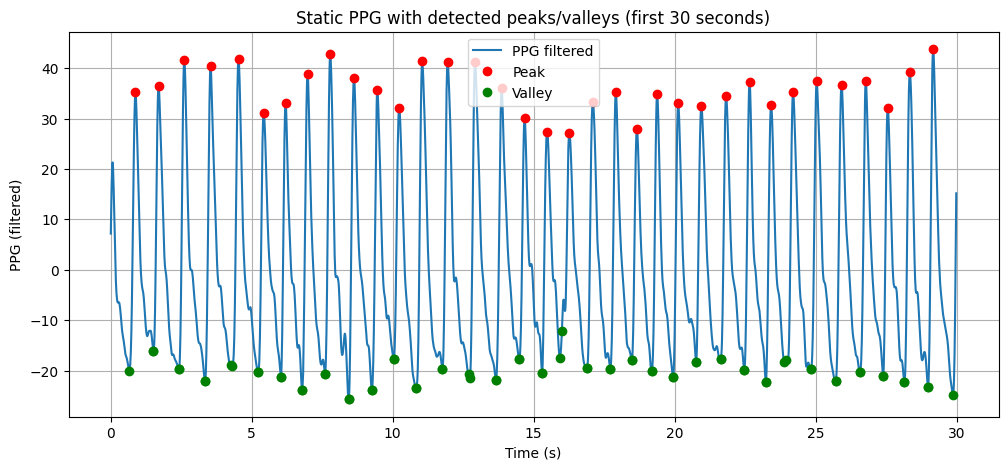

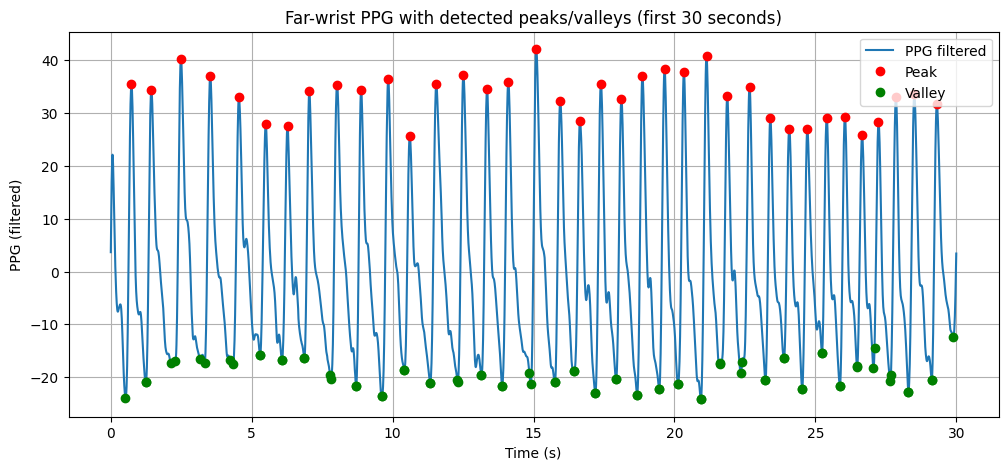

In [ ]:
def plot_pulses_with_markers(df, peaks, starts, ends, title, duration_sec=5):
    time_s = df["time_s"].values
    ppg    = df["ppg_filt"].values.astype(float)

    t0 = time_s[0]
    mask = (time_s - t0) <= duration_sec

    plt.figure(figsize=(12,5))
    plt.plot(time_s[mask] - t0, ppg[mask], label="PPG filtered")

    # mark peaks and valleys in this window
    for pk, s_idx, e_idx in zip(peaks, starts, ends):
        if (s_idx is None) or (e_idx is None):
            continue
        t_pk = time_s[pk] - t0
        t_s  = time_s[s_idx] - t0
        t_e  = time_s[e_idx] - t0
        if t_pk < 0 or t_pk > duration_sec:
            continue

        plt.plot(t_pk, ppg[pk], "ro", label="Peak" if "Peak" not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.plot(t_s,  ppg[s_idx], "go", label="Valley" if "Valley" not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.plot(t_e,  ppg[e_idx], "go")

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("PPG (filtered)")
    plt.legend()
    plt.show()

plot_pulses_with_markers(
    df_static_filt,
    peaks_static,
    starts_static,
    ends_static,
    title="Static PPG with detected peaks/valleys (first 30 seconds)",
    duration_sec=30
)

plot_pulses_with_markers(
    df_farwrist_filt,
    peaks_far,
    starts_far,
    ends_far,
    title="Far-wrist PPG with detected peaks/valleys (first 30 seconds)",
    duration_sec=30
)

In [ ]:
def plot_feature_hist(features_df, col, title):
    plt.figure(figsize=(6,4))
    vals = features_df[col].dropna().values
    plt.hist(vals, bins=40, alpha=0.7)
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

# plot_feature_hist(features_static, "As", "Static - Systolic Amplitude (As)")
# plot_feature_hist(features_static, "Pw", "Static - Pulse Width (Pw)")
# plot_feature_hist(features_static, "Tc", "Static - Crest Time (Tc)")
# plot_feature_hist(features_static, "Pi_over_As", "Static - Pi/As")
# plot_feature_hist(features_static, "Ab_over_Aa", "Static - Ab_w / Aa_w")

In [ ]:
# @title
# # @title
# import numpy as np
# import pandas as pd
# from scipy.stats import kurtosis, skew
# import matplotlib.pyplot as plt

# def compute_ma_stats(df_segment):
#     """
#     df_segment: a pulse segment with 'ppg_filt'
#     Return kurtosis, skewness, std.
#     """
#     x = df_segment["ppg_filt"].values
#     return {
#         "kurtosis": kurtosis(x, fisher=False),
#         "skewness": skew(x),
#         "std": np.std(x)
#     }

# def detect_ma(features_df, df_signal, window_sec=10):
#     """
#     features_df: output of segmentation (static or farwrist)
#     df_signal: full PPG with time_s and ppg_filt
#     """
#     # Compute thresholds from clean data (use static as baseline)
#     # For now, derive from features_df itself.
#     # Later you will use static-only or a reference segment.
#     kurt_list = []
#     skew_list = []
#     std_list = []
#     segment_info = []

#     for _, row in features_df.iterrows():
#         s = int(row["start_idx"])
#         e = int(row["end_idx"])
#         seg = df_signal.iloc[s:e+1]

#         stats = compute_ma_stats(seg)
#         kurt_list.append(stats["kurtosis"])
#         skew_list.append(stats["skewness"])
#         std_list.append(stats["std"])
#         segment_info.append(stats)

#     # threshold based on 95th percentile
#     th_kurt = np.percentile(kurt_list, 95)
#     th_skew = np.percentile(skew_list, 95)
#     th_std  = np.percentile(std_list,  95)

#     print("MA detection thresholds:")
#     print("  kurtosis <", th_kurt)
#     print("  skewness <", th_skew)
#     print("  std      <", th_std)

#     # detect MA
#     ma_flags = []
#     for stats in segment_info:
#         is_ma = (
#             (stats["kurtosis"] > th_kurt) or
#             (stats["skewness"] > th_skew) or
#             (stats["std"]      > th_std)
#         )
#         ma_flags.append(is_ma)

#     features_df["is_MA"] = ma_flags
#     return features_df, (th_kurt, th_skew, th_std)

In [ ]:
# @title
# # @title
# def classify_ma_window(features_df, window_sec=10):
#     """
#     Determine if window is FAR-wrist MA or NEAR-wrist MA.
#     """
#     total = len(features_df)
#     ma_cnt = features_df["is_MA"].sum()
#     lam = ma_cnt / max(total, 1)

#     print(f"λ = {lam:.3f}  (MA ratio)")

#     if lam >= 0.3:
#         print("→ Classified as NEAR-wrist MA (remove)")
#         return "NEAR"
#     else:
#         print("→ Classified as FAR-wrist MA (mitigate)")
#         return "FAR"

In [ ]:
# @title
# # @title
# def apply_smaf(df_signal, features_df, N=4):
#     """
#     Apply SMAF for FAR-wrist MA pulses.
#     """
#     df_signal = df_signal.copy()
#     ppg = df_signal["ppg_filt"].values

#     clean_segments = []
#     for _, row in features_df.iterrows():
#         if not row["is_MA"]:
#             s = int(row["start_idx"])
#             e = int(row["end_idx"])
#             clean_segments.append(ppg[s:e+1])

#     # prepare averaged shape
#     if len(clean_segments) < N:
#         print("Not enough clean segments for SMAF. Skipping.")
#         return df_signal

#     ref = clean_segments[:N]
#     max_len = max(len(seg) for seg in ref)
#     aligned = []

#     for seg in ref:
#         aligned.append(np.interp(np.linspace(0, 1, max_len),
#                                  np.linspace(0, 1, len(seg)), seg))

#     avg_clean = np.mean(np.vstack(aligned), axis=0)

#     # apply SMAF for MA segments
#     for _, row in features_df.iterrows():
#         if row["is_MA"]:
#             s = int(row["start_idx"])
#             e = int(row["end_idx"])
#             seg = ppg[s:e+1]
#             seg_interp = np.interp(np.linspace(0, 1, max_len),
#                                    np.linspace(0, 1, len(seg)),
#                                    seg)
#             mitigated = (avg_clean * N + seg_interp) / (N + 1)
#             # write back
#             ppg[s:e+1] = np.interp(np.arange(len(seg)),
#                                    np.linspace(0, len(seg)-1, max_len),
#                                    mitigated)

#     df_signal["ppg_filt_smaf"] = ppg
#     return df_signal

In [ ]:
# @title
# # @title
# # Static
# feat_static_ma, th_static = detect_ma(features_static, df_static_filt)
# cls_static = classify_ma_window(feat_static_ma)

# # Far-wrist
# feat_far_ma, th_far = detect_ma(features_far, df_farwrist_filt)
# cls_far = classify_ma_window(feat_far_ma)

In [ ]:
# @title
# df_far_smaf = apply_smaf(df_farwrist_filt, feat_far_ma)

# plt.figure(figsize=(12,5))
# plt.plot(df_farwrist_filt["time_s"], df_farwrist_filt["ppg_filt"], alpha=0.4, label="Filtered")
# plt.plot(df_far_smaf["time_s"], df_far_smaf["ppg_filt_smaf"], linewidth=2, label="After SMAF")
# plt.legend()
# plt.title("Far-wrist PPG: Before vs After SMAF")
# plt.xlabel("Time (s)")
# plt.ylabel("PPG")
# plt.show()

# Pulse waveform dataset 만들기
### 숨김 코드: `extract_pulse_waveforms(df_signal, features_df, seq_len=150)`
> return np.array(pulses)  # shape: (N, seq_len)

In [ ]:
# @title
# def extract_pulse_waveforms(df_signal, features_df, seq_len=150):
#     """
#     Extract pulse waveforms using start_idx and end_idx from features_df.
#     Resample each pulse to fixed length seq_len.
#     """
#     pulses = []
#     for _, row in features_df.iterrows():
#         start_time = int(row["start_idx"])
#         end_time = int(row["end_idx"])

#         x = df_signal["ppg_filt"].values[start_time:end_time+1] # if "ppg_filt" in df_signal.columns else df_signal["ppg_filt_smaf"].values[start_time:end_time+1]

#         # Resample to seq_len
#         old_indices = np.linspace(0, 1, len(x))
#         new_indices = np.linspace(0, 1, seq_len)
#         x_resampled = np.interp(new_indices, old_indices, x)
#         pulses.append(x_resampled)

#     print(f"Extracted {len(pulses)} pulses.")
#     return np.array(pulses)  # shape: (N, seq_len)

# `extract_pulse_waveforms()` -> 피크 인덱스 정렬 필요

In [ ]:
import numpy as np

def extract_pulse_waveforms_fix_peak(
        df_signal,
        features_df,
        seq_len: int = 150,
        peak_pos_ratio: float = 0.2,   # 피크를 전체 길이 중 어디에 둘지(0~1)
        col: str = "ppg_filt"
    ):
    """
    features_df: start_idx, end_idx, peak_idx (모두 원 신호의 인덱스) 포함
    seq_len: 리샘플 후 길이
    peak_pos_ratio: 피크를 [0, 1] 구간에서 어느 위치에 둘지 (예: 0.4 -> 40%)
    col: 사용할 PPG 컬럼 이름
    """
    pulses = []
    signal = df_signal[col].values

    # resampled 벡터에서 피크가 올 타겟 위치
    target_peak = int(round(seq_len * peak_pos_ratio))
    # 너무 양 끝으로 가지 않게 살짝 제한
    target_peak = max(1, min(seq_len - 2, target_peak))

    for _, row in features_df.iterrows():
        s = int(row["start_idx"])
        e = int(row["end_idx"])
        p = int(row["peak_idx"])

        # peak이 구간 밖에 있으면 건너뜀
        if not (s <= p <= e):
            continue

        x = signal[s:e+1]              # 한 심주기
        L = len(x)
        orig_peak = p - s              # 이 구간 내부에서의 피크 위치

        left_len = orig_peak           # 피크까지 왼쪽 샘플 개수
        right_len = L - orig_peak - 1  # 피크 이후 오른쪽 샘플 개수

        # 타겟 구간에서 피크 기준 앞/뒤 길이
        left_target_len = target_peak
        right_target_len = seq_len - target_peak - 1

        # ----- 왼쪽(시작~피크) 리샘플 -----
        if left_len > 0 and left_target_len > 0:
            old_left = np.linspace(0, left_len, left_len + 1)
            new_left = np.linspace(0, left_len, left_target_len + 1)
            left_res = np.interp(new_left, old_left, x[:orig_peak + 1])
        else:
            # 너무 짧을 때는 피크 값으로 채움
            left_res = np.full(left_target_len + 1, x[orig_peak])

        # ----- 오른쪽(피크~끝) 리샘플 -----
        if right_len > 0 and right_target_len > 0:
            old_right = np.linspace(0, right_len, right_len + 1)
            new_right = np.linspace(0, right_len, right_target_len + 1)
            right_res = np.interp(new_right, old_right, x[orig_peak:])
        else:
            right_res = np.full(right_target_len + 1, x[orig_peak])

        # 왼쪽 마지막(피크)와 오른쪽 첫 번째(피크)가 겹치므로 하나만 남기고 concat
        x_resampled = np.concatenate([left_res[:-1], right_res])

        # 길이 안전 확인 (디버깅용)
        if len(x_resampled) != seq_len:
            # 필요하면 여기서 assert나 logging 추가 가능
            x_resampled = x_resampled[:seq_len]

        pulses.append(x_resampled)

    print(f"Extracted {len(pulses)} pulses (aligned).")
    return np.vstack(pulses)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

#ppg 신호에서 하나의 맥파 구간 잘라내기
#잘라낸 펄스는 각각 길이가 다르기 때문에 150개 샘플로 길이 맞춰서 resampling

# Extract static pulses
static_pulses = extract_pulse_waveforms(df_static_filt, features_static, seq_len=150)
far_pulses = extract_pulse_waveforms(df_farwrist_filt, features_far, seq_len=150)

# Extract far-wrist pulses (after SMAF!)
# far_pulses = extract_pulse_waveforms(df_far_smaf, feat_far_ma, seq_len=150)

print("Static pulses:", static_pulses.shape)
print("Far-wrist pulses:", far_pulses.shape)

Extracted 72 pulses.
Extracted 80 pulses.
Static pulses: (72, 150)
Far-wrist pulses: (80, 150)


# pulse sanity check 그래프

In [ ]:
# @title
# # @title
# static_pulses[:5]

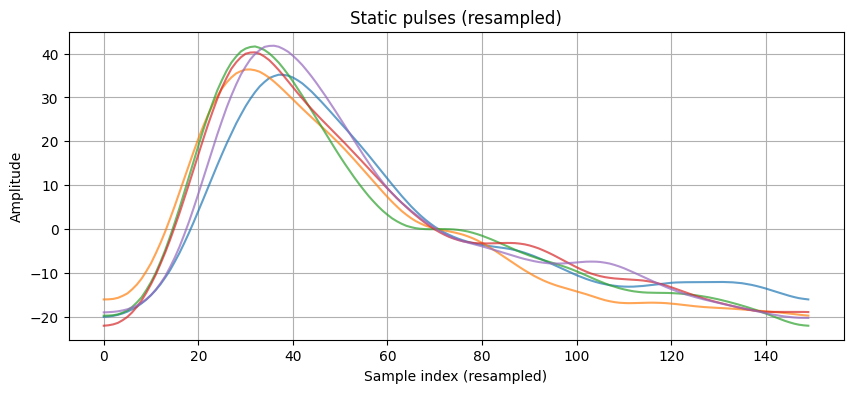

In [ ]:
def plot_random_pulses(pulses, title, n=5):
    plt.figure(figsize=(10,4))
    for i in range(min(n, len(pulses))):
        plt.plot(pulses[i], alpha=0.7)
    plt.title(title)
    plt.xlabel("Sample index (resampled)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

plot_random_pulses(static_pulses, "Static pulses (resampled)")
# plot_random_pulses(far_pulses, "Static pulses (resampled)")

Extracted 72 pulses (aligned).


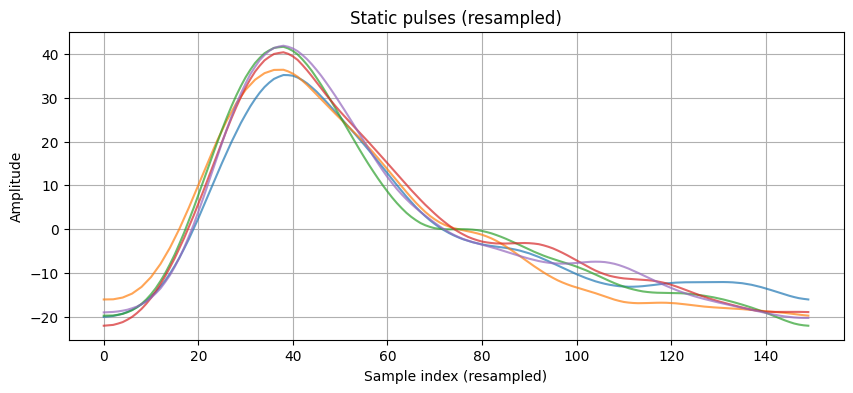

In [ ]:
static_pulses_fixed = extract_pulse_waveforms_fix_peak(
        df_static_filt,
        features_static,
        seq_len=150,
        peak_pos_ratio=0.25,
        col="ppg_filt"
    )
 plot_random_pulses(static_pulses_fixed, "Static pulses (resampled)")

Extracted 80 pulses (aligned).


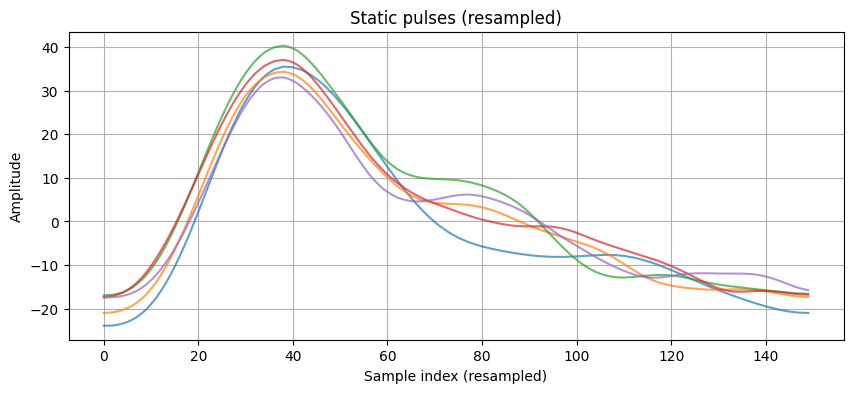

In [ ]:
far_pulses_fixed = extract_pulse_waveforms_fix_peak(
        df_farwrist_filt,
        features_far,
        seq_len=150,
        peak_pos_ratio=0.25,
        col="ppg_filt"
    )
plot_random_pulses(far_pulses_fixed, "Static pulses (resampled)")

In [ ]:
import math
import matplotlib.pyplot as plt

def plot_all_pulses(pulses, cols=10):
    """
    pulses: numpy array (N, seq_len)
    cols: subplot에서 한 행에 몇 개 출력할지
    """
    N, seq_len = pulses.shape

    rows = math.ceil(N / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2), sharex=True, sharey=True)
    axes = axes.flatten()

    for i in range(len(axes)):
        ax = axes[i]
        if i < N:
            ax.plot(pulses[i])
            ax.set_title(f"{i}", fontsize=8)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')   # 남는 subplot 숨기기

    plt.tight_layout()
    plt.show()

(72, 150)


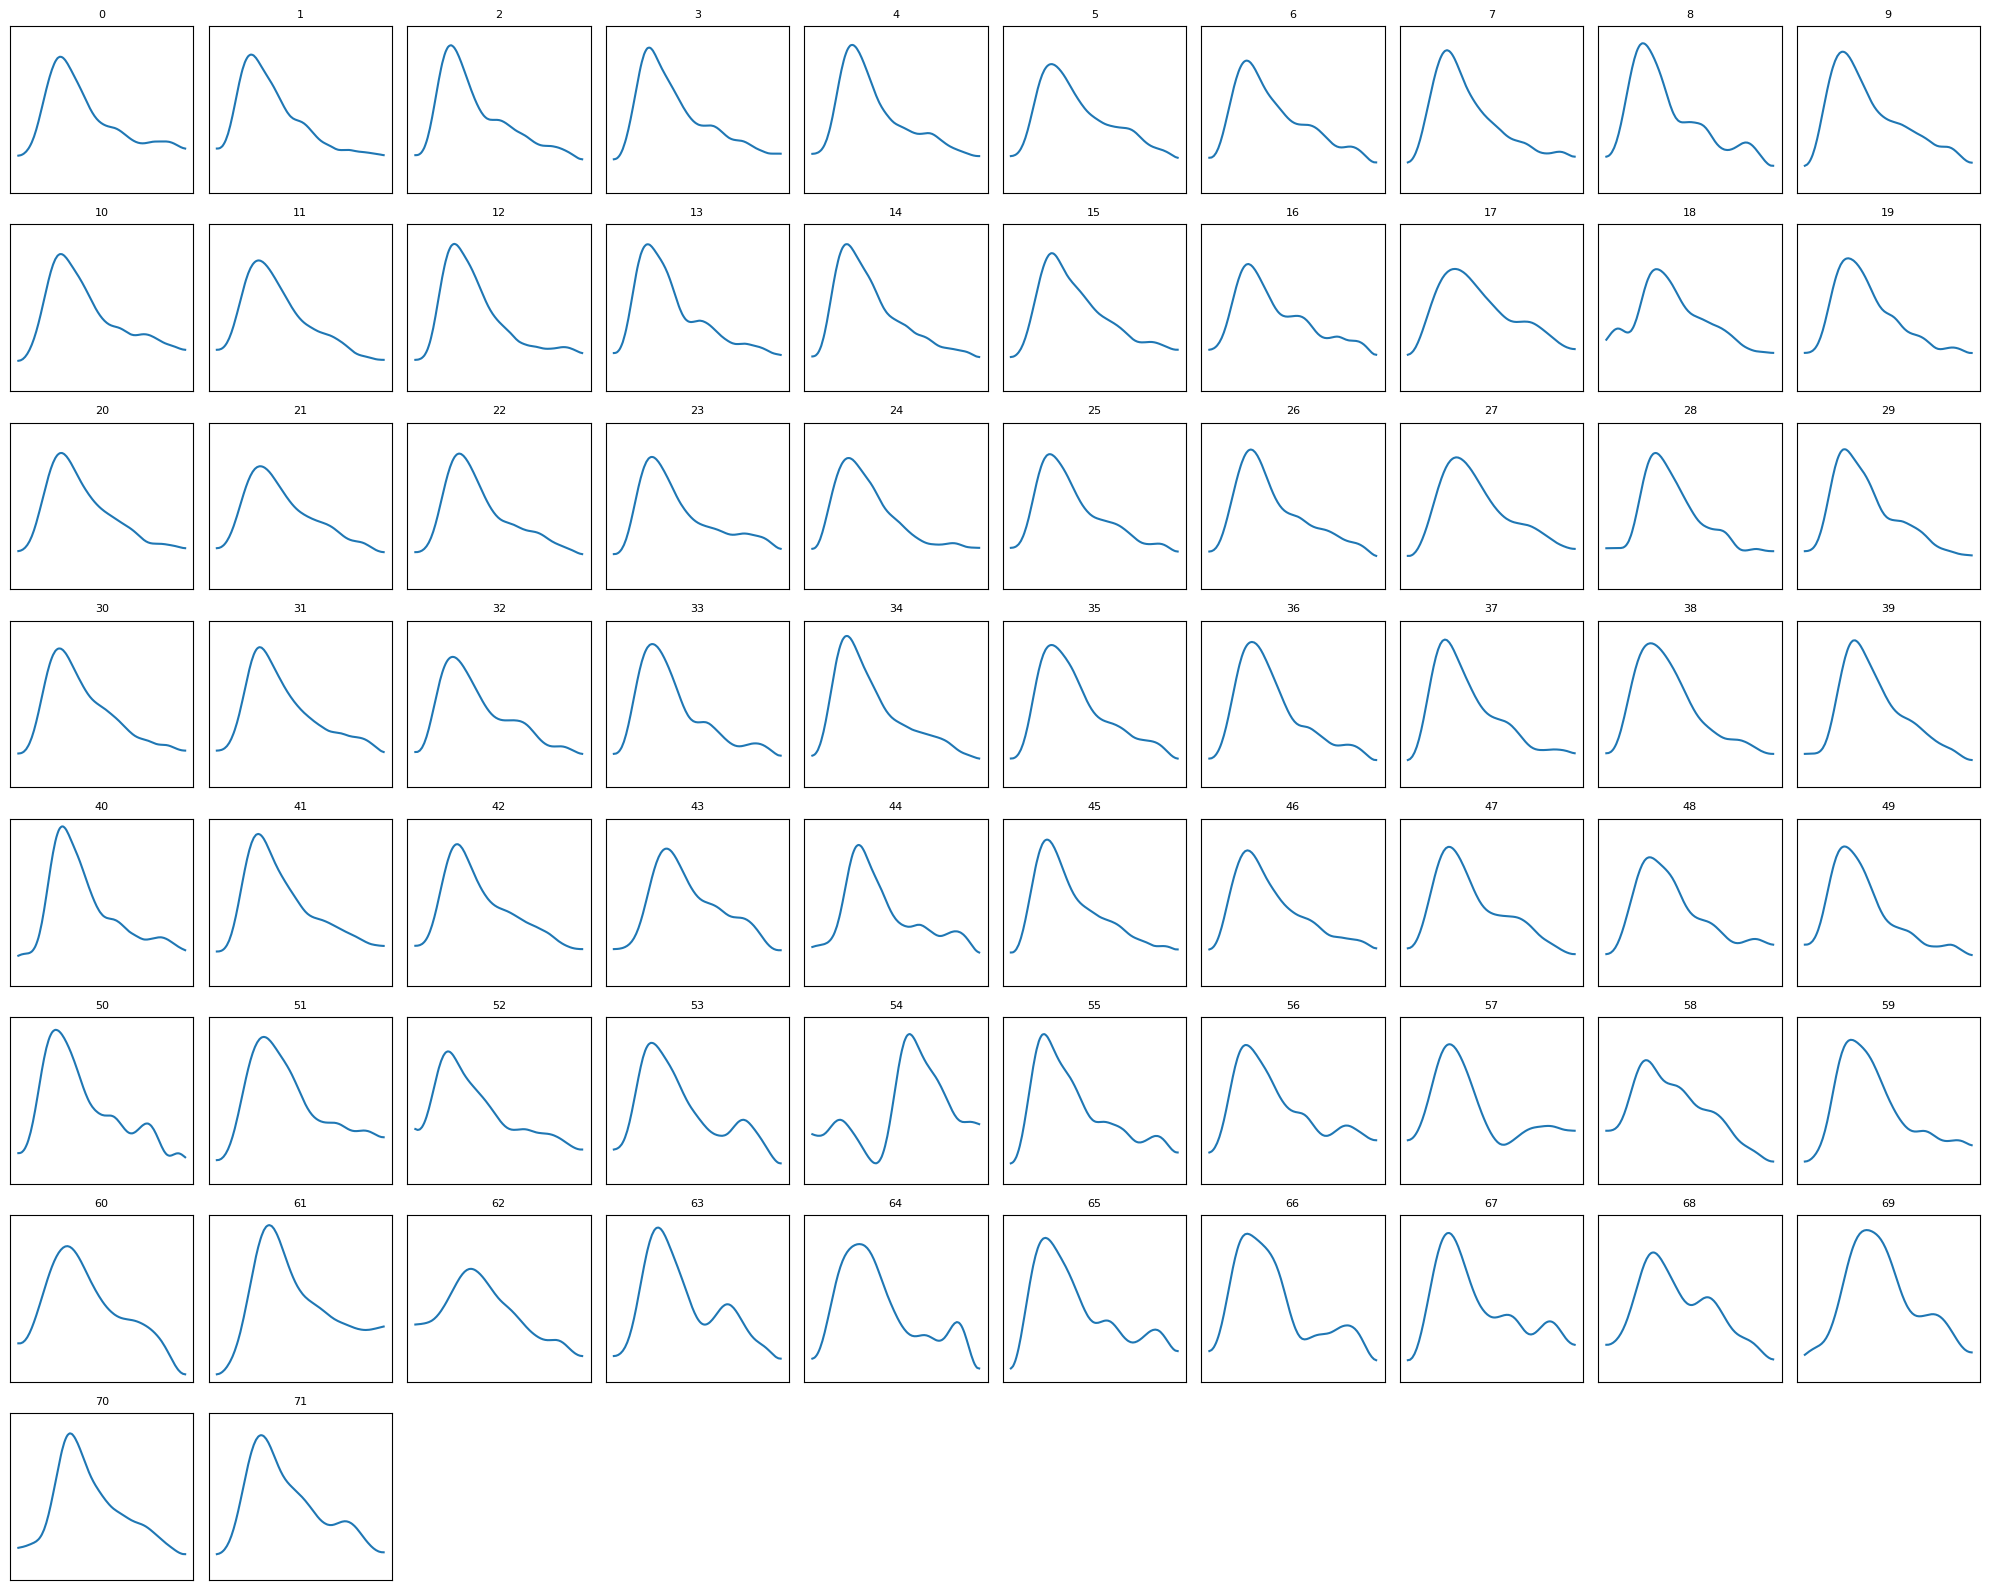

In [ ]:
print(static_pulses.shape)
plot_all_pulses(static_pulses, cols=10)

### `outliers = [ ]` <- 여기에 제거할 인덱스 번호 입력

In [ ]:
import numpy as np

outliers = []  # 제거할 인덱스
static_clean = np.delete(static_pulses_fixed, outliers, axis=0)
print(static_clean.shape)

(72, 150)


# Autoencoder 정의 + 데이터셋 준비(정규화 포함)

Per-pulse z-score 정규화는 “각 사람의 고유한 PPG 신호 특징 일부를 제거하거나 흐리게 만들 가능성"이 존재
> amplitude 차이, baseline offset pulse마다의 energy difference 특징들을 지워버림

### Pulse-level normalization은 제거하고 새로 AI 모델링 해야...

In [ ]:
# @title
# # @title
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader

# device = "cuda" if torch.cuda.is_available() else "cpu"
# print("Using device:", device)

# # ----- normalize pulses (per-pulse z-score) -----
# # pulse마다 amplitude(진폭), offset이 달라서 파형 형태(shape)만 비교하고 싶을 때 유용
# def normalize_pulses(pulses):
#     # pulses: (N, seq_len)
#     mean = pulses.mean(axis=1, keepdims=True)
#     std  = pulses.std(axis=1, keepdims=True) + 1e-6
#     return (pulses - mean) / std

# static_pulses_norm = normalize_pulses(static_pulses)
# # far_pulses_norm = normalize_pulses(far_pulses)

# # clean_pulses = np.concatenate([static_pulses_norm, far_pulses_norm], axis=0)
# clean_pulses = static_pulses_norm.copy()
# print("Clean pulses array:", clean_pulses.shape)

# # quick check
# print("Mean of first pulse (should be ~0):", clean_pulses[0].mean())
# print("Std  of first pulse (should be ~1):", clean_pulses[0].std())

# # ----- Dataset / DataLoader -----
# class PulseDataset(Dataset):
#     def __init__(self, arr):
#         self.arr = torch.from_numpy(arr).float()
#     def __len__(self):
#         return len(self.arr)
#     def __getitem__(self, idx):
#         x = self.arr[idx]          # (seq_len,)
#         x = x.unsqueeze(0)         # (1, seq_len)  # channel dim
#         return x

# seq_len = clean_pulses.shape[1]
# dataset = PulseDataset(clean_pulses)
# loader  = DataLoader(dataset, batch_size=32, shuffle=True)

# print("Dataset size:", len(dataset))

# # ----- 1D CNN Autoencoder -----
# class AE(nn.Module):
#     def __init__(self, seq_len):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv1d(1, 16, 5, stride=2, padding=2),  # -> L/2
#             nn.ReLU(),
#             nn.Conv1d(16, 32, 5, stride=2, padding=2), # -> L/4
#             nn.ReLU()
#         )
#         self.seq_len = seq_len
#         latent_dim = (seq_len // 4) * 32
#         self.fc_enc = nn.Linear(latent_dim, 64)
#         self.fc_dec = nn.Linear(64, latent_dim)

#         self.decoder = nn.Sequential(
#             nn.ConvTranspose1d(32, 16, 4, stride=2, padding=1), # -> L/2
#             nn.ReLU(),
#             nn.ConvTranspose1d(16, 1, 4, stride=2, padding=1)   # -> L
#         )

#     def forward(self, x):
#         h = self.encoder(x)                    # (B,32,L/4)
#         h_flat = h.view(h.size(0), -1)         # (B, latent_dim)
#         z = self.fc_enc(h_flat)                # (B, 64)
#         h_dec = self.fc_dec(z)                 # (B, latent_dim)
#         h_dec = h_dec.view(x.size(0), 32, self.seq_len // 4)
#         x_hat = self.decoder(h_dec)            # (B,1,L)
#         return x_hat, z

# model = AE(seq_len).to(device)
# print(model)

# AE 클래스 + 학습 루프

In [ ]:
# @title
# # @title
# import torch
# import torch.nn as nn
# import numpy as np
# import matplotlib.pyplot as plt

# # =========================================
# # Autoencoder with automatic shape detection + final output trimming
# # =========================================
# class AE(nn.Module):
#     def __init__(self, seq_len):
#         super().__init__()

#         self.seq_len = seq_len

#         # ----- Encoder -----
#         self.encoder = nn.Sequential(
#             nn.Conv1d(1, 16, 5, stride=2, padding=2),  # → approx L/2
#             nn.ReLU(),
#             nn.Conv1d(16, 32, 5, stride=2, padding=2), # → approx L/4
#             nn.ReLU()
#         )

#         # ----- Compute output shape automatically -----
#         with torch.no_grad():
#             dummy = torch.zeros(1, 1, seq_len)
#             h = self.encoder(dummy)              # (1, C, Lenc)
#             self.enc_out_shape = h.shape         # save
#             self.flatten_dim = h.numel()         # C * Lenc

#         print("Encoder output shape:", self.enc_out_shape)
#         print("Flatten dim:", self.flatten_dim)

#         # ----- Latent layers -----
#         self.fc_enc = nn.Linear(self.flatten_dim, 64)
#         self.fc_dec = nn.Linear(64, self.flatten_dim)

#         # ----- Decoder -----
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose1d(32, 16, 4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose1d(16, 1, 4, stride=2, padding=1)
#         )

#     def forward(self, x):
#         B = x.size(0)

#         # Encode
#         h = self.encoder(x)
#         h_flat = h.view(B, -1)
#         z = self.fc_enc(h_flat)

#         # Decode
#         h_dec = self.fc_dec(z)
#         h_dec = h_dec.view(
#             B,
#             self.enc_out_shape[1],
#             self.enc_out_shape[2]
#         )
#         x_hat = self.decoder(h_dec)

#         # ----- Trim extra length if decoder made it longer -----
#         if x_hat.shape[-1] > self.seq_len:
#             x_hat = x_hat[:, :, :self.seq_len]

#         return x_hat, z


# # Instantiate model
# model = AE(seq_len).to(device)
# print(model)

In [ ]:
# @title
# pip install torchinfo

In [ ]:
# @title
# from torchinfo import summary

# summary(model, input_size=(1, 1, seq_len))

# 학습 + 중간 reconsruction 그래프

In [ ]:
# @title
# # @title
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.MSELoss()

# epochs = 25  # CPU면 15~25 정도가 적당

# for epoch in range(epochs):
#     model.train()
#     total_loss = 0.0

#     for batch in loader:
#         batch = batch.to(device)          # (B,1,L)
#         optimizer.zero_grad()
#         x_hat, _ = model(batch)
#         loss = criterion(x_hat, batch)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item() * batch.size(0)

#     avg_loss = total_loss / len(dataset)
#     print(f"[Epoch {epoch+1:02d}/{epochs}] train loss = {avg_loss:.6f}")

#     # ---- reconstruction check every 5 epochs ----
#     if (epoch + 1) % 5 == 0:
#         model.eval()
#         with torch.no_grad():
#             idx = np.random.randint(len(dataset))  # 랜덤 pulse 하나
#             x = dataset[idx].unsqueeze(0).to(device)   # (1,1,L)
#             x_hat, _ = model(x)

#         x_np     = x.cpu().numpy().reshape(-1)
#         x_hat_np = x_hat.cpu().numpy().reshape(-1)

#         plt.figure(figsize=(10,4))
#         plt.plot(x_np,     label="Original", alpha=0.7)
#         plt.plot(x_hat_np, label="Reconstructed", linewidth=2)
#         plt.title(f"Reconstruction check (epoch {epoch+1})")
#         plt.xlabel("Sample index")
#         plt.ylabel("Normalized amplitude")
#         plt.legend()
#         plt.grid(True)
#         plt.show()

# clean pulse에 대한 reconsruction error 분포

In [ ]:
# @title
# # @title
# model.eval()
# recon_losses = []

# with torch.no_grad():
#     for pulse in clean_pulses:
#         x = torch.tensor(pulse).float().unsqueeze(0).unsqueeze(0).to(device)  # (1,1,L)
#         x_hat, _ = model(x)
#         loss = ((x_hat - x) ** 2).mean().item()
#         recon_losses.append(loss)

# recon_losses = np.array(recon_losses)

# plt.figure(figsize=(8,4))
# plt.hist(recon_losses, bins=30, alpha=0.8)
# plt.title("Reconstruction error distribution (clean pulses)")
# plt.xlabel("MSE loss")
# plt.ylabel("Count")
# plt.grid(True)
# plt.show()

# print("Mean loss:", recon_losses.mean())
# print("Std  loss:", recon_losses.std())
# print("95th percentile:", np.percentile(recon_losses, 95))
# print("99th percentile:", np.percentile(recon_losses, 99))

# 정상만 학습하는 one-class anomaly detection 문제 정의

### 모델 사용 예시
```
seq_len = 150
latent_dim = 16

ae_model = build_ppg_cnn_autoencoder(seq_len=seq_len, latent_dim=latent_dim)
ae_model.summary()
```

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_ppg_cnn_autoencoder(seq_len=150, latent_dim=16):
    """
    PPG 심주기(길이 seq_len)를 입력으로 받는 1D CNN Autoencoder 정의.
    - 입력 shape: (seq_len, 1)
    - 출력 shape: (seq_len, 1)
    - latent_dim: 잠재벡터 차원
    """
    # ----- Encoder -----
    inputs = keras.Input(shape=(seq_len, 1))

    x = layers.Conv1D(32, kernel_size=5, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling1D(pool_size=2, padding="same")(x)   # (seq_len/2)

    x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(pool_size=2, padding="same")(x)   # (seq_len/4)

    x = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(pool_size=2, padding="same")(x)   # (seq_len/8)

    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, name="latent")(x)       # 잠재 벡터

    # ----- Decoder -----
    # 인코더 마지막 Conv 출력 크기 복원 (seq_len/8, 128 채널)
    # seq_len=150이면 150/8=18.75 → padding='same' 때문에 실제 길이는 19로 잡히는 경우가 많음
    # 여기서는 conv 블록 길이를 고정해서 맞춰줌
    conv_len = seq_len // 8 + (seq_len % 8 > 0)  # 대략적인 역길이

    x = layers.Dense(conv_len * 128, activation="relu")(latent)
    x = layers.Reshape((conv_len, 128))(x)

    x = layers.UpSampling1D(size=2)(x) # Corrected: Apply UpSampling1D to x
    x = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(x)

    x = layers.UpSampling1D(size=2)(x) # Corrected: Apply UpSampling1D to x
    x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)

    x = layers.UpSampling1D(size=2)(x) # Corrected: Apply UpSampling1D to x
    x = layers.Conv1D(32, kernel_size=5, padding="same", activation="relu")(x)

    # 최종 출력: 원래와 동일한 길이(seq_len)를 맞추기 위해 잘라주거나 패딩
    x = layers.Conv1D(1, kernel_size=3, padding="same", activation="linear")(x)

    # 길이 보정: 필요시 Lambda로 앞/뒤를 잘라서 정확히 seq_len로 맞추기
    x = layers.Lambda(lambda t: t[:, :seq_len, :])(x)

    outputs = x

    model = keras.Model(inputs, outputs, name="ppg_cnn_autoencoder")
    return model

seq_len = 150
latent_dim = 16

ae_model = build_ppg_cnn_autoencoder(seq_len=seq_len, latent_dim=latent_dim)
ae_model.summary()

Model: "ppg_cnn_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 150, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 75, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 75, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 38, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 38, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2432)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 16)             │        38,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2432)           │        41,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_12 (UpSampling1D) │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 38, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_13 (UpSampling1D) │ (None, 76, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 76, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_14 (UpSampling1D) │ (None, 152, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 152, 32)        │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 152, 1)         │            97 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 150, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,145 (844.32 KB)

 Trainable params: 216,145 (844.32 KB)

 Non-trainable params: 0 (0.00 B)

## reconstruction error(): 디코더 출력 기반 scoring 함수

In [ ]:
def reconstruction_error(pulses, model, method="mse"):
    """
    pulses : (N, seq_len) 또는 (N, seq_len, 1)
    model  : trained autoencoder
    method : "mse" or "mae"

    return : errors (N,)
    """
    # 0) 디버깅용: 들어온 거 타입/shape 찍어보기
    print(">> [reconstruction_error] raw pulses type:", type(pulses))
    if hasattr(pulses, "shape"):
        print(">> [reconstruction_error] raw pulses shape:", pulses.shape)

    # 1) 무조건 텐서로 변환
    x = tf.convert_to_tensor(pulses, dtype=tf.float32)

    # 2) 차원 맞추기
    if x.shape.rank == 2:          # (N, seq_len)
        x = tf.expand_dims(x, -1)  # (N, seq_len, 1)
    elif x.shape.rank == 3:
        pass                       # 이미 (N, seq_len, 1) 같은 형태라고 가정
    else:
        raise ValueError(f"pulses의 rank가 이상합니다: {x.shape}")

    print(">> [reconstruction_error] prepared x shape:", x.shape)

    # 3) predict 대신 직접 forward (Keras 3에서 더 안전)
    x_hat = model(x, training=False)   # 텐서로 결과 나옴

    # 4) 오류 계산 (텐서 연산)
    if method == "mse":
        errors = tf.reduce_mean((x - x_hat) ** 2, axis=(1, 2))
    elif method == "mae":
        errors = tf.reduce_mean(tf.abs(x - x_hat), axis=(1, 2))
    else:
        raise ValueError("method must be 'mse' or 'mae'")

    # 넘파이로 반환
    return errors.numpy()

### 사용 예시
> `errors = reconstruction_error(test_pulses, ae_model, method="mse")`

> 아래에서 학습 후에 사용함 (신호 복원 오류 확인)

### 임계치 설정
* EER기반
* ROC Curve 기반

등등...

> **코드 숨김 처리**

In [ ]:
# @title
# # @title
# from sklearn.metrics import roc_curve
# import numpy as np

# def compute_eer_threshold(errors_normal, errors_attack):
#     # 레이블: 정상(0), 공격자(1)
#     y_true = np.concatenate([
#         np.zeros_like(errors_normal),
#         np.ones_like(errors_attack)
#     ])

#     # 점수: reconstruction error (높을수록 공격자)
#     y_scores = np.concatenate([errors_normal, errors_attack])

#     # FPR, TPR, thresholds 계산
#     fpr, tpr, thresholds = roc_curve(y_true, y_scores)

#     # FRR = 1 - TPR
#     fnr = 1 - tpr

#     # EER = FPR = FNR 되는 threshold 찾기
#     abs_diffs = np.abs(fpr - fnr)
#     idx = np.argmin(abs_diffs)

#     eer = fpr[idx]
#     threshold = thresholds[idx]

#     print(f"EER: {eer:.4f}")
#     print(f"Threshold (EER): {threshold:.4f}")

#     return threshold, eer

In [ ]:
# @title
# # @title
# threshold, eer = compute_eer_threshold(errors_normal, errors_attack)

# # 테스트 pulse의 점수
# test_error = 0.123

# if test_error > threshold:
#     print("→ 공격자 / 이상치")
# else:
#     print("→ 정상 사용자")

* 원시 CSV → time axis 보정 → 대역통과 필터링
* → peak detection → start/end valley detection
* → pulse segmentation → resampling → normalization
* → AE 학습 입력으로 사용

In [ ]:
import numpy as np
from tensorflow import keras

# pulses shape: (N,150)
pulses = static_clean.astype("float32")

# reshape: (N,150,1)
pulses = np.expand_dims(pulses, axis=-1)

from sklearn.model_selection import train_test_split

x_train, x_val = train_test_split(
    static_clean, test_size=0.2, shuffle=True, random_state=42
)

print(x_train.shape)
print(x_val.shape)

(57, 150)
(15, 150)


In [ ]:
# plot_all_pulses(x_val, cols=10)

outliers = [9]  # 제거할 인덱스
val_clean = np.delete(x_val, outliers, axis=0)
print(val_clean.shape)

(14, 150)


## 심주기 정규화

In [ ]:
# @title
# # Min-Max 정규화 -> 사용 안 하고 z 스코어 정규화만 수행
# import numpy as np
# x_norm = np.zeros_like(norm_x_train)

# for i in range(norm_x_train.shape[0]):
#     x = norm_x_train[i, :, 0]
#     x_min = x.min()
#     x_max = x.max()

#     x_norm[i, :, 0] = (x - x_min) / (x_max - x_min + 1e-8)

In [ ]:
# @title
# # Z-score 정규화 (평균 0, 표준편차 1, 심주기별 적용)
# x_norm = np.zeros_like(norm_x_train)

# for i in range(norm_x_train.shape[0]):
#     x = norm_x_train[i, :, 0]
#     mean = x.mean()
#     std = x.std()

#     x_norm[i, :, 0] = (x - mean) / (std + 1e-8)
# print("Min value of x_norm[0]:", x_norm[0].min())
# print("Max value of x_norm[0]:", x_norm[0].max())

### z스코어 정규화 모듈

In [ ]:
print(x_train.shape)
print(type(x_train))
print("---")
print("Min value of x_train[0]:", x_train[0].min())
print("Max value of x_train[0]:", x_train[0].max())

(57, 150)
<class 'numpy.ndarray'>
---
Min value of x_train[0]: -21.258695518431455
Max value of x_train[0]: 34.91834974362786


In [ ]:
def normalize_ppg_batch(arr, method="zscore"):
    """
    입력으로 np 배열 입력받아서 복사 후 각 심주기 (150으로 리샘플링)를
    정규화하는 모듈
    """
    arr = np.array(arr)  # 안전한 복사
    N, L, C = arr.shape

    norm_arr = np.zeros_like(arr)

    for i in range(N):
        sample = arr[i, :, 0]  # shape = (150,)

        if method == "zscore":
            mean = sample.mean()
            std = sample.std()

            # std=0 보호
            if std == 0:
                norm = sample - mean
            else:
                norm = (sample - mean) / std

        elif method == "minmax":
            min_v = sample.min()
            max_v = sample.max()
            range_v = max_v - min_v

            if range_v == 0:
                norm = sample - min_v
            else:
                norm = (sample - min_v) / range_v

        else:
            raise ValueError("method must be 'zscore' or 'minmax'")

        norm_arr[i, :, 0] = norm

    return norm_arr

In [ ]:
# 실제 정규화 수행
x_train_norm = normalize_ppg_batch(x_train, method="zscore")
x_val_norm = normalize_ppg_batch(x_val, method="zscore")

## 오토인코더 학습
주석을 제거하여 사용

> 아래는 정규화 데이터로 학습 (위에서 데이터 정규화 코드 실행 필요)

In [ ]:
# @title
# ae_norm_model.compile(optimizer=keras.optimizers.Adam(1e-3),
#                  loss="mse")

# history = ae_norm_model.fit(
#     x_train_norm, x_train_norm,
#     validation_data=(x_val_norm, x_val_norm),
#     epochs=50,
#     batch_size=32
# )
# # 학습을 마치면 모델 저장
# ae_norm_model.save("ae_norm_model.h5")

> 아래는 정규화 X 데이터로 학습 (숨김 코드)

In [ ]:
ae_model.compile(optimizer=keras.optimizers.Adam(1e-3),
                 loss="mse")

history = ae_model.fit(
    x_train, x_train,
    validation_data=(x_val, x_val),
    epochs=50,
    batch_size=36
)
# 학습을 마치면 모델 저장
ae_model.save("ae_model_1203_v2.h5")

### loss 커브 시각화

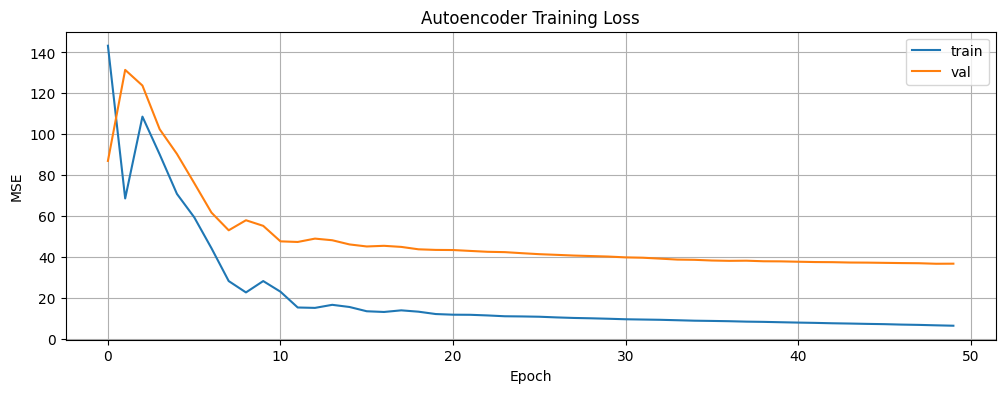

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

### 복원 품질 시각화

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


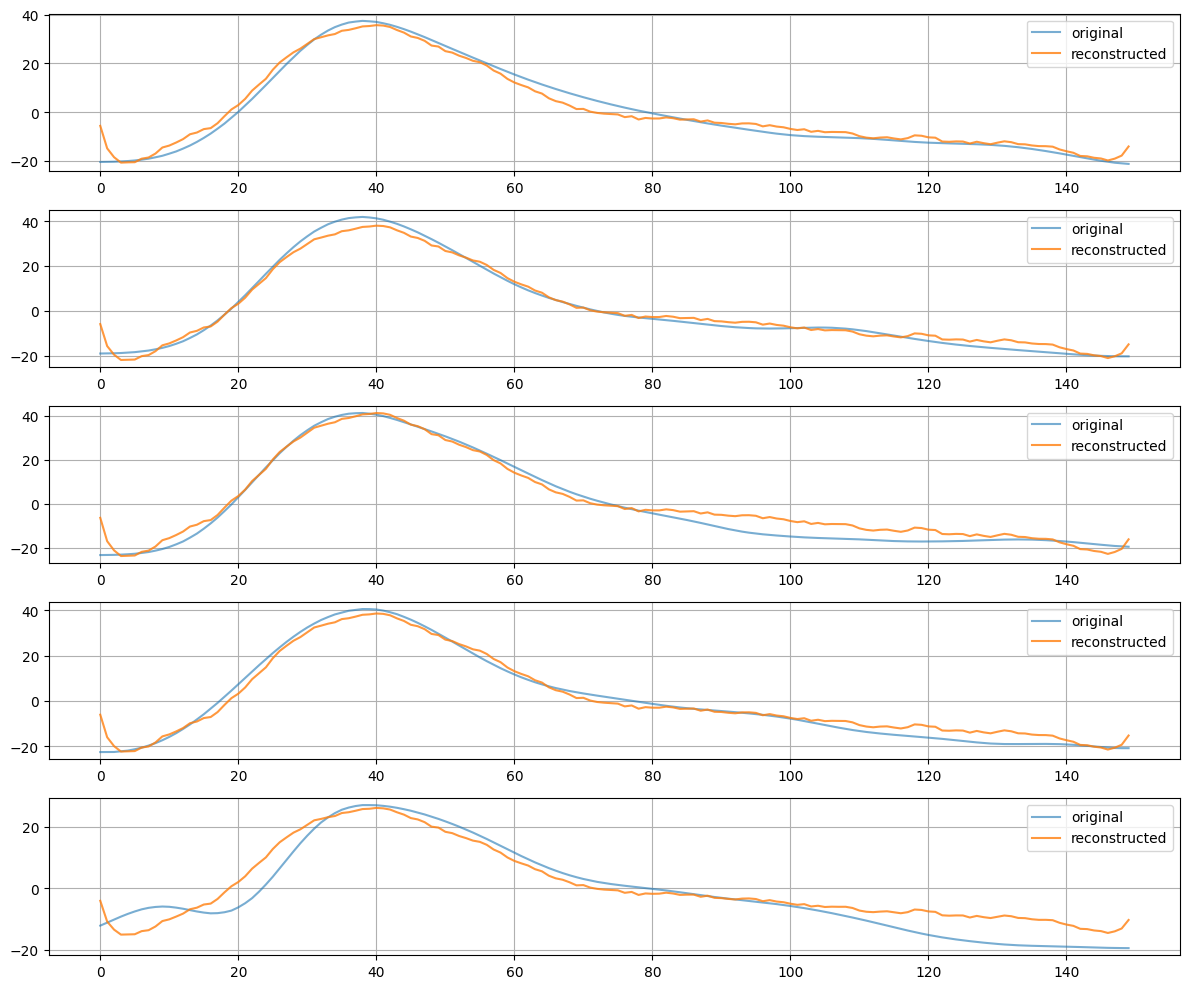

In [ ]:
idx = np.random.choice(len(x_val), 5, replace=False)

plt.figure(figsize=(12,10))

for i, n in enumerate(idx, 1):
    x = x_val[n:n+1]
    x_hat = ae_model.predict(x)

    plt.subplot(5,1,i)
    plt.plot(x.squeeze(), label="original", alpha=0.6)
    plt.plot(x_hat.squeeze(), label="reconstructed", alpha=0.8)
    plt.legend()

plt.tight_layout()
plt.show()

```
def reconstruction_error(pulses, model, method="mse"):
    """
    pulses : (N, seq_len)
    model  : trained autoencoder
    method : "mse" or "mae"

    return : errors (N,)
    """
```

In [ ]:
errors = reconstruction_error(x_val, ae_model, method="mse")
# errors_normal = reconstruction_error(clean_pulses, ae_model, x_val)

print("평균 오류:", np.mean(errors))
print("오류 최소~최대:", np.min(errors), np.max(errors))

>> [reconstruction_error] raw pulses type: <class 'numpy.ndarray'>
>> [reconstruction_error] raw pulses shape: (15, 150)
>> [reconstruction_error] prepared x shape: (15, 150, 1)
평균 오류: 36.74743
오류 최소~최대: 1.1863409 464.67734


### 오류 분포 시각화

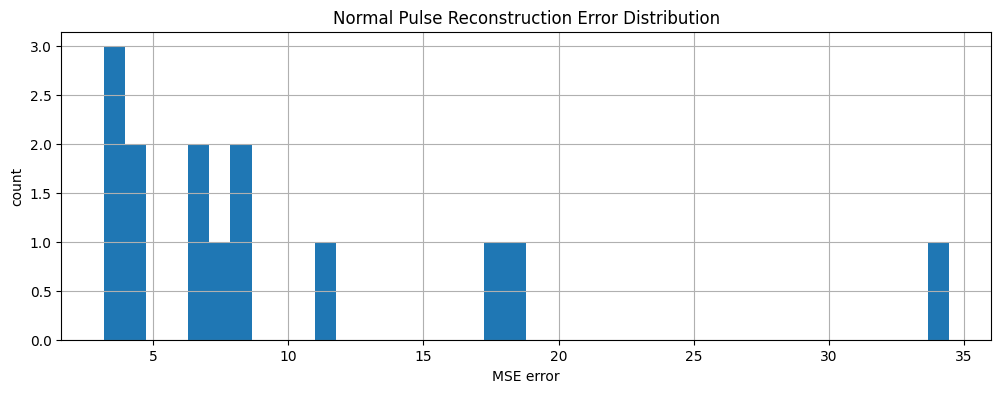

In [ ]:
plt.hist(errors, bins=40)
plt.title("Normal Pulse Reconstruction Error Distribution")
plt.xlabel("MSE error")
plt.ylabel("count")
plt.show()

# 공격 데이터로 복원률 확인

In [ ]:
# # 이 셀에서 ae_norm_model.h5라는 오토인코더를 로드
# from tensorflow.keras.models import load_model
# import tensorflow as tf

# ae_norm_model = load_model(
#     "ae_norm_model.h5",
#     custom_objects={"mse": tf.keras.losses.MeanSquaredError()}
# )

추정된 샘플링 주파수 ≈ 100.00 Hz

Plotting: Attacker PPG (first 8 seconds)
Using samples = 801 (approx 8 seconds)


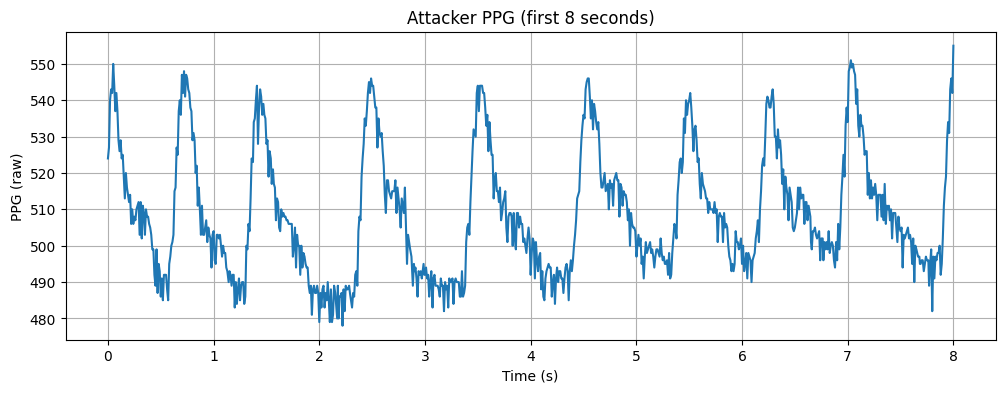

In [ ]:
# attacker_path = "/content/stand_esther.csv"
# attacker_path = "/content/p1_walk.csv"
# attacker_path = "/content/static_esther_2.csv"
attacker_path = "/content/p1_static.csv"
df_att = pd.read_csv(attacker_path)

df_att, fs_att = prepare_time_axis(df_att)

plot_ppg(df_att, fs_att,   "Attacker PPG (first 8 seconds)")

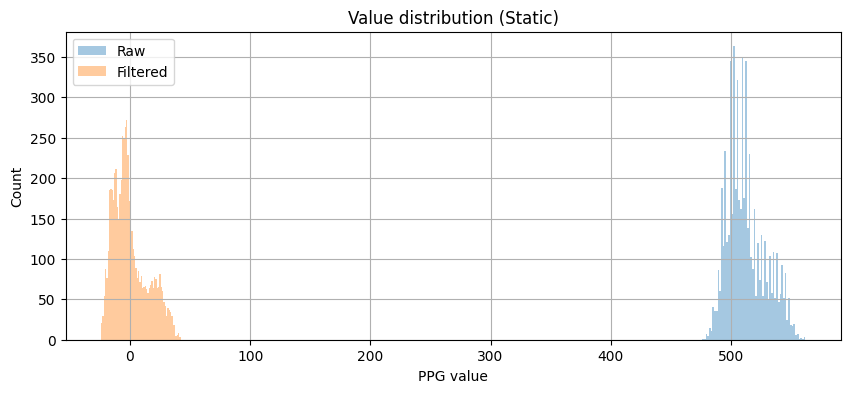

In [ ]:
b_att, a_att = design_bandpass(fs_att, low_cut, high_cut, order)
df_att_filt = apply_bandpass(df_att, b_att, a_att)
compare_hist(df_att_filt, "ppg", "ppg_filt", "Value distribution (Static)")

In [ ]:
features_att, (peaks_att, starts_att, ends_att) = extract_pulse_features(
    df_att_filt,
    fs_att,
    ppg_col="ppg_filt",
    label="attacker"
)

print("\nAttacker feature head:")
display(features_att.head())

Detected 81 systolic peaks.
1개의 심주기 오류 발생으로 Drop
Extracted 80 pulses with features.

Attacker feature head:


,t_peak,As,Pw,Pi_over_As,Tc,Ab_over_Aa,start_idx,peak_idx,end_idx,label
0,24.424174,59.463224,0.220034,0.011940,0.209998,0.607682,52,73,124,attacker
1,25.134194,55.372384,0.260003,0.018962,0.199990,0.258715,124,144,213,attacker
2,26.184187,57.273726,0.249993,0.018158,0.199997,0.366562,229,249,318,attacker
3,27.224189,54.446169,0.239977,0.018734,0.200008,0.354556,333,353,423,attacker
4,28.244181,50.540548,0.230008,0.018797,0.220000,0.394790,433,455,529,attacker


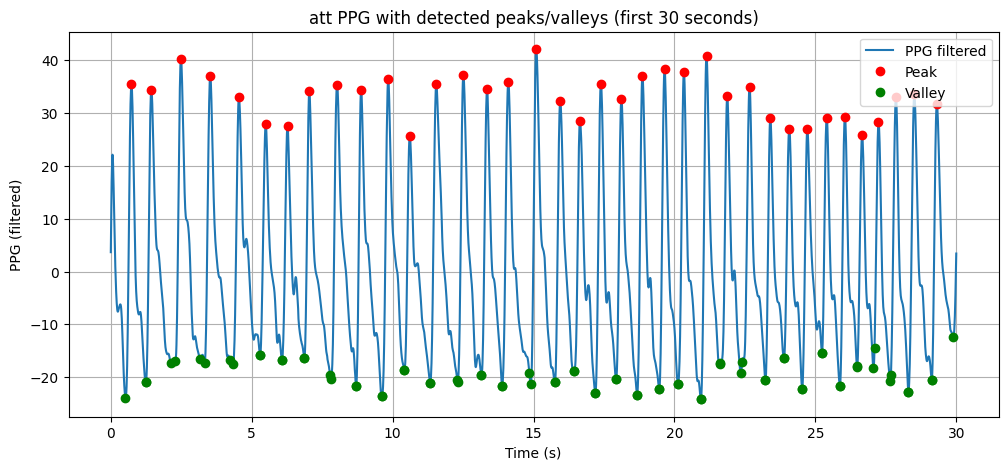

In [ ]:
plot_pulses_with_markers(
    df_att_filt,
    peaks_att,
    starts_att,
    ends_att,
    title="att PPG with detected peaks/valleys (first 30 seconds)",
    duration_sec=30
)

In [ ]:
att_pulses = extract_pulse_waveforms(df_att_filt, features_att, seq_len=150)

Extracted 80 pulses.


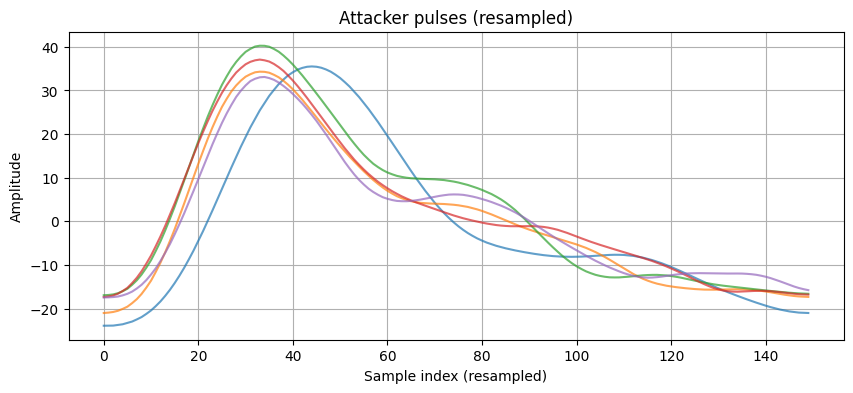

In [ ]:
plot_random_pulses(att_pulses, "Attacker pulses (resampled)")

(72, 150)


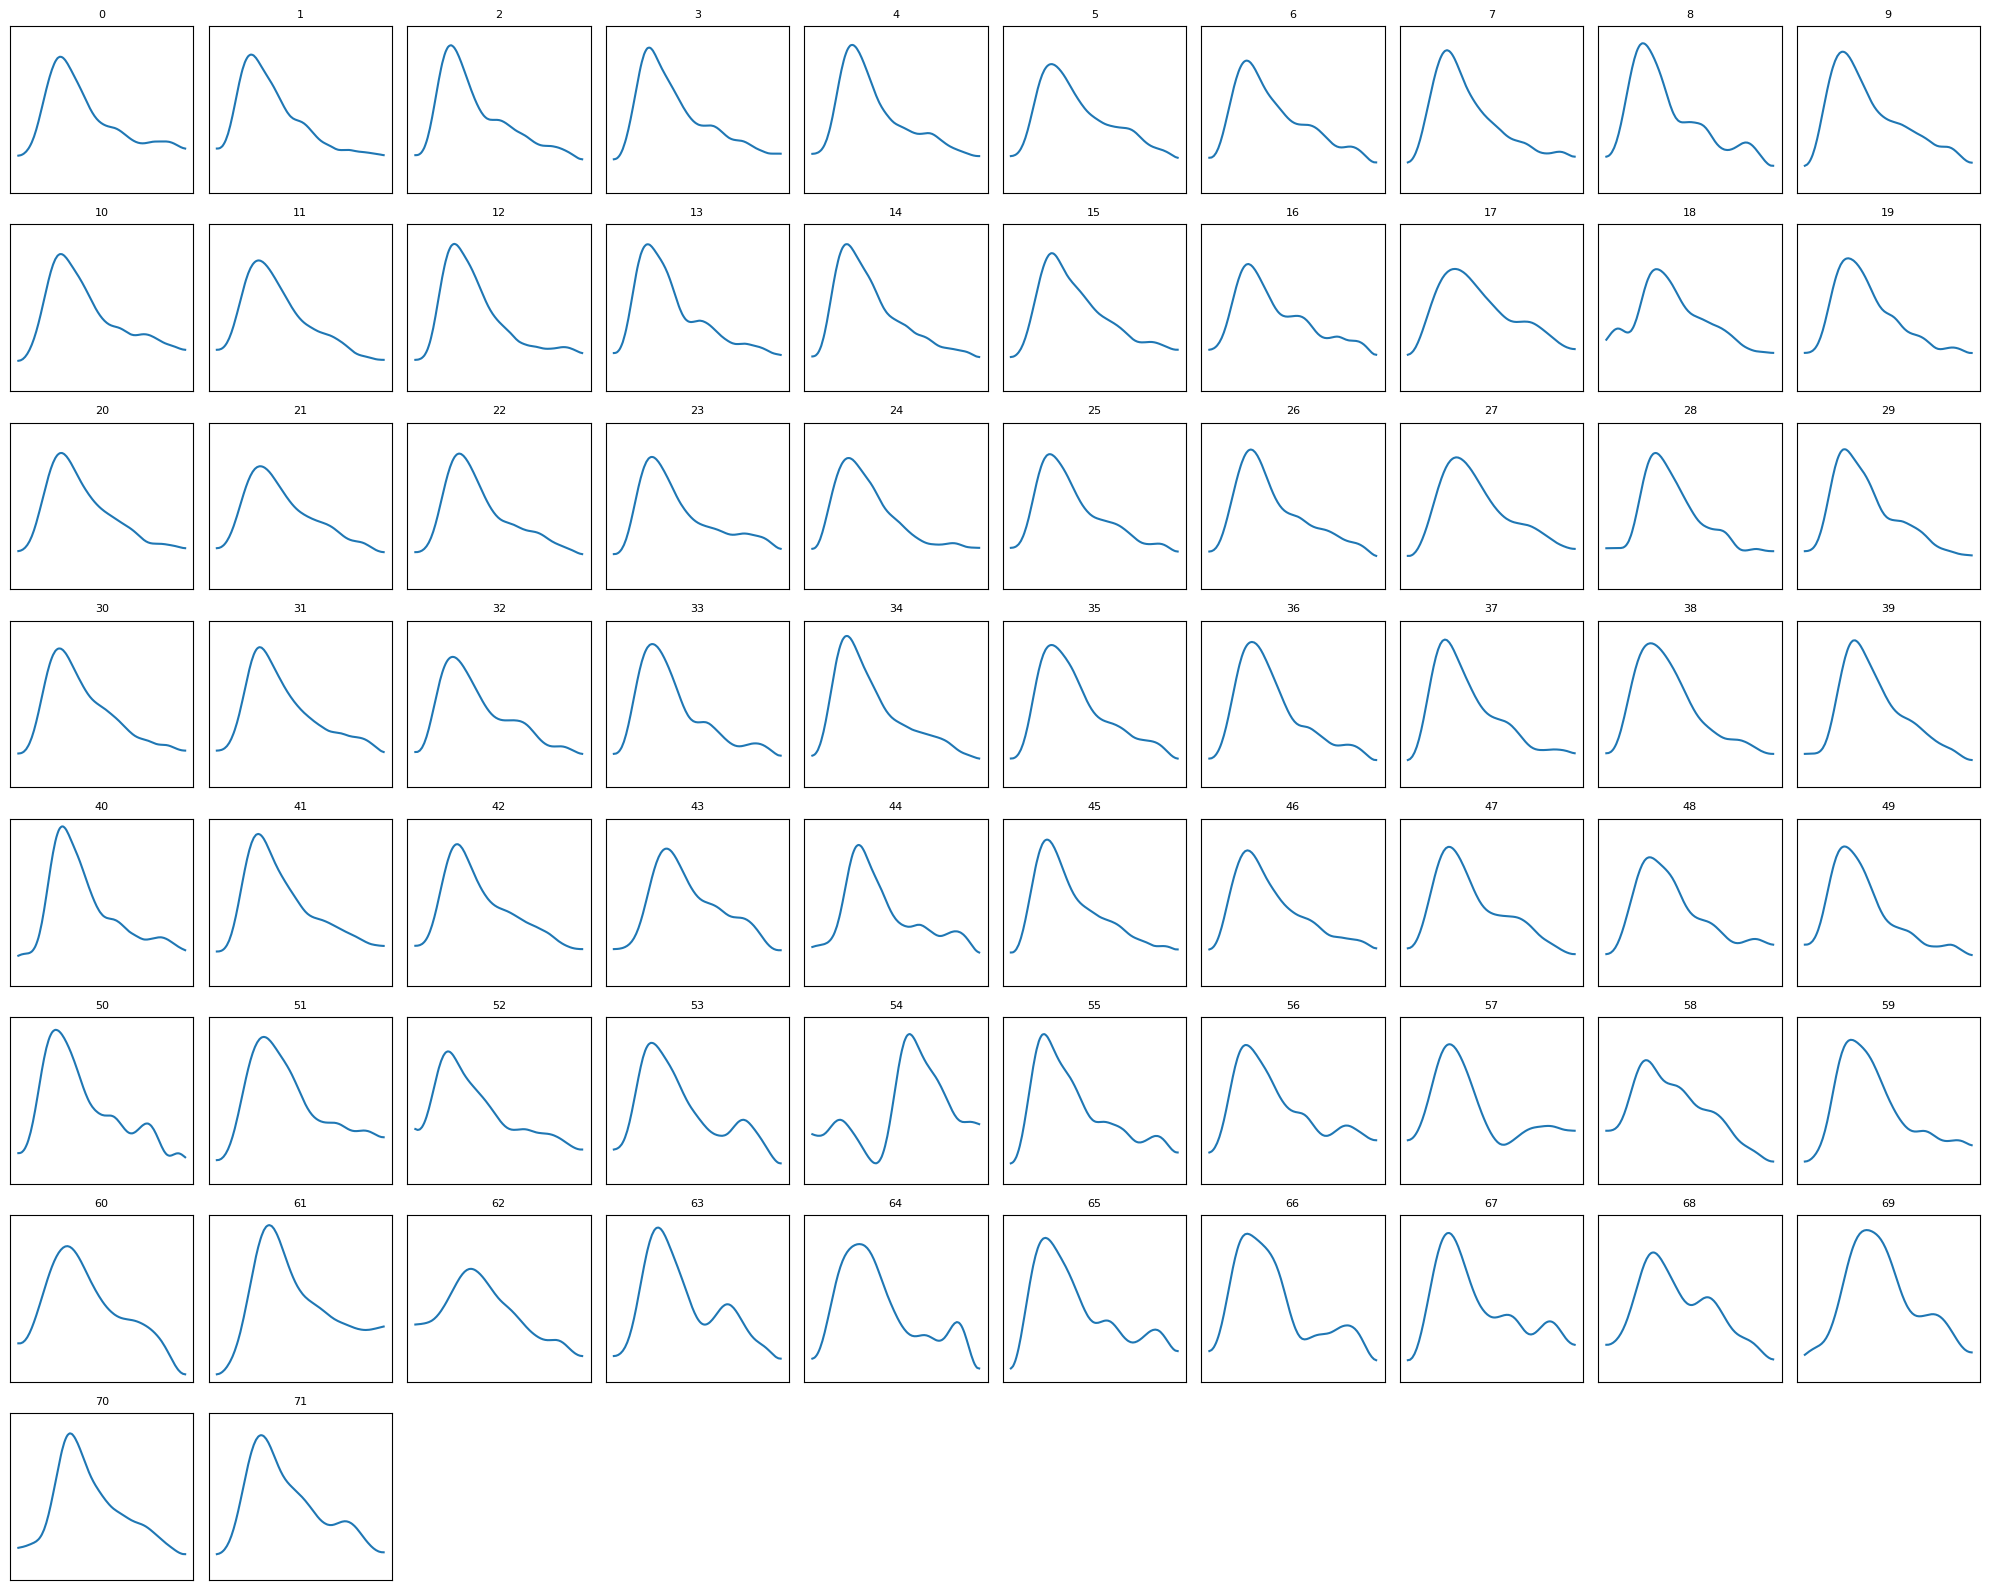

In [ ]:
print(att_pulses.shape)
plot_all_pulses(att_pulses, cols=10)
# plot_all_pulses(att_clean, cols=10)

In [ ]:
import numpy as np

outliers = []  # 제거할 인덱스
att_clean = np.delete(att_pulses, outliers, axis=0)
print(att_clean.shape)

(80, 150)


> 차원 오류 생기면 아래 코드 실행

In [ ]:
# # 차원 추가
# att_clean = np.expand_dims(att_clean, axis=-1)

In [ ]:
# # 차원 제거
# att_clean =att_clean.squeeze(-1)
# print(att_clean.shape)

(93, 150)


In [ ]:
# # 정규화
# print(att_clean.shape)
# att_clean = normalize_ppg_batch(att_clean, method="zscore")
# print(att_clean.shape)

(93, 150, 1)
(93, 150, 1)


In [ ]:
att_errors = reconstruction_error(att_clean, ae_model, method="mse")

print("평균 오류:", np.mean(att_errors))
print("오류 최소~최대:", np.min(att_errors), np.max(att_errors))

평균 오류: 10.04061768758377
오류 최소~최대: 1.4410020324023163 24.37440815916166
